In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#from datasets import load_datasets_and_vocabs, my_collate
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tree import *

import spacy
from transformers import AutoConfig, AutoTokenizer
from transformers import HfArgumentParser, PreTrainedTokenizer
from dataclasses import dataclass, field
from typing import Optional
from datasets import load_dataset, Dataset
import os
from spacy.tokens import Doc
from random_words import RandomWords
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from lemminflect import getInflection

import argparse
import json
import re
import sys

from allennlp.predictors.predictor import Predictor
from lxml import etree
from nltk.tokenize import TreebankWordTokenizer
from tqdm import tqdm

from torch.nn.utils.rnn import pad_sequence
import codecs
import linecache
import logging
import pickle
from collections import Counter, defaultdict
from copy import copy, deepcopy

import simplejson as json
from allennlp.modules.elmo import batch_to_ids
from lxml import etree
from nltk import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from torch.utils.data import DataLoader, Dataset

import argparse
import json
import os
import re
import sys

from allennlp.predictors.predictor import Predictor
from lxml import etree
from nltk.tokenize import TreebankWordTokenizer
from tqdm import tqdm

import warnings
warnings.filterwarnings('always')


nltk.download('omw-1.4')
nltk.download("wordnet")

random.seed(12345)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

## CLINE Framework

In [3]:
Doc.set_extension('_synonym_sent', default=False)
Doc.set_extension('_synonym_intv', default=False)
Doc.set_extension('_ori_syn_intv', default=False)
Doc.set_extension('_antonym_sent', default=False)
Doc.set_extension('_antonym_intv', default=False)
Doc.set_extension('_ori_ant_intv', default=False)

file_path = "data/twitter/train.txt"
model_path = "biaffine-dependency-parser-ptb-2020.04.06.tar.gz"

predictor = Predictor.from_path(model_path)


rw = RandomWords()

REPLACE_RATIO = 0.3

REPLACE_ORIGINAL = 0
REPLACE_LEMMINFLECT = 1
REPLACE_SYNONYM = 2
REPLACE_HYPERNYMS = 3
REPLACE_ANTONYM = 4
REPLACE_RANDOM = 5
REPLACE_ADJACENCY = 6

REPLACE_NONE = -100

SYNONYM_RATIO = 1/3
HYPERNYMS_RATIO = 1/3
LEMMINFLECT_RATIO = 1/3

ANTONYM_RATIO = 1/2
RANDOM_RATIO = 1/2

REPLACE_TAG = ['NN', 'NNS', 'JJ', 'JJR', 'JJS', 'RB', 'RBR',
               'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']  # [NNP, NNPS]
REPLACE_POS = ['NOUN', 'VERB', 'ADJ', 'ADV']
POS_TO_TAGS = {'NOUN': ['NN', 'NNS'],
               'ADJ': ['JJ', 'JJR', 'JJS'],
               'VERB': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
               'ADV': ['RB', 'RBR', 'RBS']}


def get_synonym(token):
    lemma = token.lemma_
    text = token.text
    tag = token.tag_
    pos = token.pos_
    word_synset = set()
    if pos not in REPLACE_POS:
        return list(word_synset)

    synsets = wn.synsets(text, pos=eval("wn."+pos))
    for synset in synsets:
        words = synset.lemma_names()
        for word in words:
            # word = wnl.lemmatize(word, pos=eval("wn."+pos))
            if word.lower() != text.lower() and word.lower() != lemma.lower():
                # inflt = getInflection(word, tag=tag)
                # word = inflt[0] if len(inflt) else word
                word = word.replace('_', ' ')
                word_synset.add(word)

    return list(word_synset)


def get_hypernyms(token):
    lemma = token.lemma_
    text = token.text
    tag = token.tag_
    pos = token.pos_
    word_hypernyms = set()
    if pos not in REPLACE_POS:
        return list(word_hypernyms)

    synsets = wn.synsets(text, pos=eval("wn."+pos))
    for synset in synsets:
        for hyperset in synset.hypernyms():
            words = hyperset.lemma_names()
            for word in words:
                # word = wnl.lemmatize(word, pos=eval("wn."+pos))
                if word.lower() != text.lower() and word.lower() != lemma.lower():
                    # inflt = getInflection(word, tag=tag)
                    # word = inflt[0] if len(inflt) else word
                    word = word.replace('_', ' ')
                    word_hypernyms.add(word)

    return list(word_hypernyms)


def get_antonym(token):
    lemma = token.lemma_
    text = token.text
    tag = token.tag_
    pos = token.pos_
    word_antonym = set()
    if pos not in REPLACE_POS:
        return list(word_antonym)

    synsets = wn.synsets(text, pos=eval("wn."+pos))
    for synset in synsets:
        for synlemma in synset.lemmas():
            for antonym in synlemma.antonyms():
                word = antonym.name()
                # word = wnl.lemmatize(word, pos=eval("wn."+pos))
                if word.lower() != text.lower() and word.lower() != lemma.lower():
                    # inflt = getInflection(word, tag=tag)
                    # word = inflt[0] if len(inflt) else word
                    word = word.replace('_', ' ')
                    word_antonym.add(word)

    return list(word_antonym)


def get_lemminflect(token):
    text = token.text
    lemma = token.lemma_
    tag = token.tag_
    pos = token.pos_
    word_lemminflect = set()
    if pos not in REPLACE_POS:
        return list(word_lemminflect)

    tags = POS_TO_TAGS[pos]
    for tg in tags:
        if tg == tag:
            continue
        inflects = getInflection(lemma, tag=tg)
        for word in inflects:
            if word.lower() != text.lower():
                word_lemminflect.add(word)

    return list(word_lemminflect)


def search_replacement(doc, candidate_index, replace_type, max_num, pos_to_words=None):
    sr_rep = []
    if max_num < 1:
        return sr_rep

    for r_idx in candidate_index:
        token = doc[r_idx]
        rep = None
        if replace_type == REPLACE_ANTONYM:
            reps = get_antonym(token)
            rep = random.choice(reps) if reps else None
        elif replace_type == REPLACE_ADJACENCY:
            reps = pos_to_words[token.pos_]
            rep = random.choice(reps) if reps else None
        elif replace_type == REPLACE_RANDOM:
            rep = rw.random_word()
        elif replace_type == REPLACE_SYNONYM:
            reps = get_synonym(token)
            rep = random.choice(reps) if reps else None
        elif replace_type == REPLACE_HYPERNYMS:
            reps = get_hypernyms(token)
            rep = random.choice(reps) if reps else None
        elif replace_type == REPLACE_LEMMINFLECT:
            reps = get_lemminflect(token)
            rep = random.choice(reps) if reps else None
        else:
            pass

        if rep and rep.lower() != token.text.lower():
            sr_rep.append((r_idx, rep, replace_type))

        if len(sr_rep) >= max_num:
            break

    # print("Search Replacement: \n", sr_rep)
    return sr_rep


def replace_word(doc, pairs):
    synonym_sent = []
    synonym_intv = []
    ori_syn_intv = []
    antonym_sent = []
    antonym_intv = []
    ori_ant_intv = []

    length = len(doc)
    rep_num = int(length*REPLACE_RATIO)

    rep_index = []
    # pos_word = {p:[] for p in REPLACE_POS}
    for index, token in enumerate(doc):
        if token.pos_ in REPLACE_POS:
            rep_index.append(index)
            # pos_word[token.pos_].append(token.text)

    rep_num = min(rep_num, len(rep_index))

    syn_rand = random.random()
    ant_rand = random.random()

    syn_index = rep_index[:]
    random.shuffle(syn_index)
    ant_index = rep_index[:]
    random.shuffle(ant_index)

    syn_replace = []
    ant_replace = []  # [(rep_idx, rep_word, rep_type)]

    ############### Antonym Replacement ####################
    if ant_rand < ANTONYM_RATIO:
        ant_replace = search_replacement(
            doc, candidate_index=ant_index, replace_type=REPLACE_ANTONYM, max_num=rep_num)
        # print("Ant_replace1: \n", ant_replace)

    # if not ant_replace and ant_rand < ANTONYM_RATIO + ADJACENCY_RATIO:
    #     ant_replace = search_replacement(doc, candidate_index=ant_index, replace_type=REPLACE_ADJACENCY, max_num=rep_num, pos_to_words=pos_word)

    if not ant_replace:
        ant_replace = search_replacement(
            doc, candidate_index=ant_index, replace_type=REPLACE_RANDOM, max_num=rep_num)
        # print("Ant_replace2: \n", ant_replace)

    ############### Synonym Replacement ####################
    if syn_rand < HYPERNYMS_RATIO:
        syn_replace = search_replacement(
            doc, candidate_index=syn_index, replace_type=REPLACE_HYPERNYMS, max_num=rep_num)
        # print("syn_replace1: \n", syn_replace)

    if not syn_replace and syn_rand < HYPERNYMS_RATIO + SYNONYM_RATIO:
        syn_replace = search_replacement(
            doc, candidate_index=syn_index, replace_type=REPLACE_SYNONYM, max_num=rep_num)
        # print("syn_replace2: \n", syn_replace)

    if not syn_replace:
        syn_replace = search_replacement(
            doc, candidate_index=syn_index, replace_type=REPLACE_LEMMINFLECT, max_num=rep_num)
        # print("syn_replace3:\n ", syn_replace)
    ############### Original Replacement ####################

    all_replace = ant_replace + syn_replace
    all_replace = sorted(all_replace, key=lambda x: x[0], reverse=True)
    # print("All Replace: \n", all_replace)

    ori_len = -1  # point to the space before next token
    syn_len = -1
    ant_len = -1
    rep_idx, rep_word, rep_type = all_replace.pop(
    ) if all_replace else (None, None, None)
    for index, token in enumerate(doc):
        ori = syn = ant = token.text

        while index == rep_idx:
            if rep_type in [REPLACE_SYNONYM, REPLACE_HYPERNYMS, REPLACE_LEMMINFLECT]:
                syn = rep_word
                # fix length mismatch, mx.encode for bytelevelbpe
                synonym_intv.append(
                    (syn_len, syn_len + len(syn.encode('utf-8')), rep_type))
                ori_syn_intv.append(
                    (ori_len, ori_len + len(ori.encode('utf-8')), rep_type))
            elif rep_type in [REPLACE_ANTONYM, REPLACE_RANDOM]:
                ant = rep_word
                antonym_intv.append(
                    (ant_len, ant_len + len(ant.encode('utf-8')), rep_type))
                ori_ant_intv.append(
                    (ori_len, ori_len + len(ori.encode('utf-8')), rep_type))
            else:
                pass

            rep_idx, rep_word, rep_type = all_replace.pop(
            ) if all_replace else (None, None, None)

        if index in rep_index:
            if ori == syn:
                synonym_intv.append(
                    (syn_len, syn_len + len(syn.encode('utf-8')), REPLACE_ORIGINAL))
                ori_syn_intv.append(
                    (ori_len, ori_len + len(ori.encode('utf-8')), REPLACE_ORIGINAL))
            if ori == ant:
                antonym_intv.append(
                    (ant_len, ant_len + len(ant.encode('utf-8')), REPLACE_ORIGINAL))
                ori_ant_intv.append(
                    (ori_len, ori_len + len(ori.encode('utf-8')), REPLACE_ORIGINAL))

        ori_len = ori_len + len(ori.encode('utf-8')) + 1
        # +1 to point the space before next token
        syn_len = syn_len + len(syn.encode('utf-8')) + 1
        ant_len = ant_len + len(ant.encode('utf-8')) + 1

        synonym_sent.append(syn)
        antonym_sent.append(ant)

    doc._._synonym_sent = synonym_sent
    # print("Synonym Sent: \n", synonym_sent)
    synSentence = ""
    for val in synonym_sent:
        synSentence += val + " "
    pairs.append(synSentence)
    # print("Synonym Sentence Derived: ", synSentence)
    doc._._synonym_intv = synonym_intv
    # print("Synonym Intv: \n", synonym_intv)

    doc._._ori_syn_intv = ori_syn_intv
    # print("Ori Syn Intv:\n ", ori_syn_intv)

    doc._._antonym_sent = antonym_sent
    # print("Anton Sent: \n", antonym_sent)
    antSentence = ""
    for val in antonym_sent:
        antSentence += val + " "
    pairs.append(antSentence)

    doc._._antonym_intv = antonym_intv
    # print("Anton Intv: \n", antonym_intv)

    doc._._ori_ant_intv = ori_ant_intv
    # print("Ori Ant Intv: \n", ori_ant_intv)

    return doc



def createPairs(sentence):
    '''
        Input: Sentence
        Output: Tuple/List of Two Synonym and Antonym Sentences Derived

    '''
    pairs = []
    config = AutoConfig.from_pretrained(
        "nlptown/bert-base-multilingual-uncased-sentiment")
    tokenizer = AutoTokenizer.from_pretrained(
        "nlptown/bert-base-multilingual-uncased-sentiment", config="nlptown/bert-base-multilingual-uncased-sentiment")
    spacy_nlp = spacy.load("en_core_web_sm")

    # nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = spacy_nlp(sentence)
    replace_word(doc, pairs)

    return pairs


error loading _jsonnet (this is expected on Windows), treating C:\Users\harsh\AppData\Local\Temp\tmpc6ekd12n\config.json as plain json


In [4]:
def reshape_dependency_tree(as_start, as_end, dependencies, tokens=None, max_hop = 5):
    dep_tag = []
    dep_idx = []
    dep_dir = []
    # 1 hop

    for i in range(as_start, as_end):
        for dep in dependencies:
            if i == dep[1] - 1:
                # not root, not aspect
                if (dep[2] - 1 < as_start or dep[2] - 1 >= as_end) and dep[2] != 0 and dep[2] - 1 not in dep_idx:
                    if str(dep[0]) != 'punct':  # and tokens[dep[2] - 1] not in stopWords
                        dep_tag.append(dep[0])
                        dep_dir.append(1)
                    else:
                        dep_tag.append('<pad>')
                        dep_dir.append(0)
                    dep_idx.append(dep[2] - 1)
            elif i == dep[2] - 1:
                # not root, not aspect
                if (dep[1] - 1 < as_start or dep[1] - 1 >= as_end) and dep[1] != 0 and dep[1] - 1 not in dep_idx:
                    if str(dep[0]) != 'punct':  # and tokens[dep[1] - 1] not in stopWords
                        dep_tag.append(dep[0])
                        dep_dir.append(2)
                    else:
                        dep_tag.append('<pad>')
                        dep_dir.append(0)
                    dep_idx.append(dep[1] - 1)

    # add aspect and index, to make sure length matches len(tokens)
    for idx, token in enumerate(tokens):
        if idx not in dep_idx:
            dep_tag.append('<pad>')
            dep_dir.append(0)
            dep_idx.append(idx)

    index = [i[0] for i in sorted(enumerate(dep_idx), key=lambda x:x[1])]
    dep_tag = [dep_tag[i] for i in index]
    dep_idx = [dep_idx[i] for i in index]
    dep_dir = [dep_dir[i] for i in index]

    assert len(tokens) == len(dep_idx), 'length wrong'
    return dep_tag, dep_idx, dep_dir



def load_glove_embedding(word_list, glove_dir, uniform_scale, dimension_size):
    glove_words = []
    with open(os.path.join(glove_dir, 'glove.840B.300d.txt'), 'r', encoding="utf8") as fopen:
        for line in fopen:
            glove_words.append(line.strip().split(' ')[0])
    word2offset = {w: i for i, w in enumerate(glove_words)}
    word_vectors = []
    for word in word_list:
        if word in word2offset:
            line = linecache.getline(os.path.join(
                glove_dir, 'glove.840B.300d.txt'), word2offset[word]+1)
            assert(word == line[:line.find(' ')].strip())
            word_vectors.append(np.fromstring(
                line[line.find(' '):].strip(), sep=' ', dtype=np.float32))
        elif word == '<pad>':
            word_vectors.append(np.zeros(dimension_size, dtype=np.float32))
        else:
            word_vectors.append(
                np.random.uniform(-uniform_scale, uniform_scale, dimension_size))
    return word_vectors


def _default_unk_index():
    return 1

In [5]:
def mask_logits(target, mask):
    return target * mask + (1 - mask) * (-1e30)

class Gating(nn.Module):
    def __init__(self, layer_num, dim):
        super().__init__()
        self.layer_num = layer_num
        self.linear = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layer_num)])
        self.gate = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layer_num)])

    def forward(self, x):
        for i in range(self.layer_num):
            gate = torch.sigmoid(self.gate[i](x))
            nonlinear = F.relu(self.linear[i](x))
            x = gate * nonlinear + (1 - gate) * x
        return x

class DotprodAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, feature, dep_tags, dmask):
        '''
        C feature/context [N, L, D]
        Q dep_tags_v          [N, D]
        mask dmask          [N, L]
        '''

        Q = dep_tags
        Q = Q.unsqueeze(2)  # (N, D, 1)
        dot_prod = torch.bmm(feature, Q)  # (N, L, 1)
        dmask = dmask.unsqueeze(2)  # (N, D, 1)
        attention_weight = mask_logits(dot_prod, dmask)  # (N, L ,1)
        attention = F.softmax(attention_weight, dim=1)  # (N, L, 1)

        out = torch.bmm(feature.transpose(1, 2), attention)  # (N, D, 1)
        out = out.squeeze(2)
        out = torch.sigmoid(out)
        # (N, D), ([N, L]), (N, L, 1)
        return out

class RelationAttention(nn.Module):
    def __init__(self, in_dim = 300, hidden_dim = 64):
        # in_dim: the dimension fo query vector
        super().__init__()

        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, feature, dep_tags_v, dmask):
        '''
        C feature/context [N, L, D]
        Q dep_tags_v          [N, L, D]
        mask dmask          [N, L]
        '''
        Q = self.fc1(dep_tags_v)
        Q = self.relu(Q)
        Q = self.fc2(Q)  # (N, L, 1)
        Q = Q.squeeze(2)
        Q = F.softmax(mask_logits(Q, dmask), dim=1)

        Q = Q.unsqueeze(2)
        out = torch.bmm(feature.transpose(1, 2), Q)
        out = out.squeeze(2)
        # out = F.sigmoid(out)
        return out  # ([N, L])

In [6]:
class TextGraphAttentionNetwork(nn.Module):
    def __init__(self, args, dep_tag_num):
        super(TextGraphAttentionNetwork, self).__init__()
        self.args = args

        num_embeddings, embed_dim = args.glove_embedding.shape
        self.embed = nn.Embedding(num_embeddings, embed_dim)
        self.embed.weight = nn.Parameter(args.glove_embedding, requires_grad=False)
        self.dropout = nn.Dropout(args.dropout)
        self.tanh = nn.Tanh()
        self.gate = Gating(args.num_layers, args.embedding_dim)
        self.rnn = nn.GRU(input_size=args.embedding_dim, hidden_size=args.hidden_size, bidirectional=True, batch_first=True, num_layers=args.num_layers)
    
        self.gat = [DotprodAttention().to(args.device) for i in range(args.num_heads)]
        self.gat_dep = [RelationAttention(in_dim = args.embedding_dim).to(args.device) for i in range(args.num_heads)]
        
        last_hidden_size = args.hidden_size * 4

        layers = [nn.Linear(last_hidden_size, args.final_hidden_size), nn.ReLU()]
        
        for _ in range(args.num_mlps-1):
            layers += [nn.Linear(args.final_hidden_size, args.final_hidden_size), nn.ReLU()]
            
        self.dep_embed = nn.Embedding(dep_tag_num, args.embedding_dim)
        gcn_input_dim = args.hidden_size * 2
        self.fc = nn.Linear(args.embedding_dim, 2*args.hidden_size)
        self.fcs = nn.Sequential(*layers)
        self.fc_final = nn.Linear(args.final_hidden_size, args.num_classes)
        self.linear = nn.Linear(gcn_input_dim, gcn_input_dim)

    def forward(self, sentence, dep_tags):

        '''
        Forward takes:
            sentence: sentence_id of size (batch_size, text_length)
            aspect: aspect_id of size (batch_size, aspect_length)
            pos_class: pos_tag_id of size (batch_size, text_length)
            dep_tags: dep_tag_id of size (batch_size, text_length)
            text_len: (batch_size,) length of each sentence
            aspect_len: (batch_size, ) aspect length of each sentence
            dep_rels: (batch_size, text_length) relation
            dep_heads: (batch_size, text_length) which node adjacent to that node
            aspect_position: (batch_size, text_length) mask, with the position of aspect as 1 and others as 0
            dep_dirs: (batch_size, text_length) the directions each node to the aspect
        '''
        fmask = (torch.zeros_like(sentence) != sentence).float()  # (N，L)
        feature = self.embed(sentence)  # (N, L, D)
        feature = self.dropout(feature)
        feature = self.gate(feature)
        feature = self.fc(feature) # (N,L,D)
        
        dep_feature = self.dep_embed(dep_tags) 
        dep_feature = self.gate(dep_feature)

        dep_out = [g(feature, dep_feature, fmask).unsqueeze(1) for g in self.gat_dep] #(N, 1, D) * num_heads
        dep_out = torch.cat(dep_out, dim = 1) # (N, H, D)
        dep_out = dep_out.mean(dim = 1) # (N, D)
        
        #print("Shape of the feature", feature.shape)
        #print("Shape of the dep_out", dep_out.shape)
        
        gat_out = self.linear(feature) # (N, L, D)
        #print("Shape of the gat_out right now", gat_out.shape)
        fmask = fmask.unsqueeze(2)
        gat_out = gat_out * fmask
        
        #print("Shape of the gat_out after fmask", gat_out.shape)
        gat_out = F.relu(torch.sum(gat_out, dim = 1)) # (N, D)
        #print("Shape of the gat_out", gat_out.shape)
        
        feature_out = torch.cat([dep_out,  gat_out], dim = 1) # (N, D')
       
        # feature_out = gat_out
        #############################################################################################
        x = self.dropout(feature_out)
        x = self.fcs(x)
        #logit = self.fc_final(x)
        return x

In [7]:
def parsing_pipeline(given_sentence):
    sentence_dict = dict()
    parse_predict = predictor.predict(sentence=given_sentence)

    sentence_dict["sentence"] = given_sentence
    sentence_dict['tokens'] = parse_predict['words']
    sentence_dict['tags'] = parse_predict['pos']
    
    predicted_dependencies = parse_predict['predicted_dependencies']
    predicted_heads = parse_predict['predicted_heads']
    
    sentence_dict['predicted_dependencies'] = parse_predict['predicted_dependencies']
    sentence_dict['predicted_heads'] = parse_predict['predicted_heads']
    sentence_dict['dependencies'] = []
    
    for idx, item in enumerate(predicted_dependencies):
        dep_tag = item
        frm = predicted_heads[idx]
        to = idx + 1
        sentence_dict['dependencies'].append([dep_tag, frm, to])
        
    sentence_dict["aspect_sentiment"] = []
    sentence_dict['from_to'] = [] #left and right offset of the target word 

    for index_sentence, tag in enumerate(sentence_dict["tags"]):
        if tag == "NOUN" or tag=="PROPN":
            sentence_dict["aspect_sentiment"].append((sentence_dict['tokens'][index_sentence]))
            from_index = index_sentence
            if from_index != 0:
                to = sentence_dict['predicted_heads'][from_index - 1]
                if sentence_dict['predicted_heads'][from_index] == to and sentence_dict['predicted_heads'][from_index + 1] !=to:
                    to_index = sentence_dict['predicted_heads'][from_index + 1]
                else:
                    to_index = sentence_dict['predicted_heads'][from_index]
            else:
                to_index = sentence_dict['predicted_heads'][from_index]


            sentence_dict['from_to'].append((from_index, to_index))
    
    return sentence_dict

In [8]:
class Parameters:
    def __init__(self):
        pass 

args = Parameters()
 # Required parameters
args.dataset_name = 'twitter' # 'rest' 'laptop' 'twitter'
args.output_dir = 'data/output-gcn'
args.num_classes = 3
args.cuda_id = '3'
args.seed = 2022

# Model parameters
args.glove_dir = 'glove'
args.num_layers = 2
args.max_hop = 4
args.num_heads = 6
args.dropout = 0
args.num_gcn_layers = 1
args.gc_mem_dim = 300

args.gcn_dropout = 0.2
# GAT
args.gat = True
args.gat_out = True


args.gat_attention_type = 'dotprod' # 'linear' 'dotprod' 'gcn'
args.embedding_type = 'glove' # 'glove' 'bert'
args.embedding_dim = 300
args.dep_relation_embed_dim = 300
args.hidden_size = 300
args.final_hidden_size = 300
args.num_mlps = 2
# Training parameters
args.per_gpu_train_batch_size = 16
args.per_gpu_eval_batch_size = 32
args.gradient_accumulation_steps = 2
args.learning_rate = 1e-3
args.weight_decay = 0.0
args.adam_epsilon = 1e-8
args.max_grad_norm = 1.0
args.num_train_epochs = 30
args.max_steps = -1
args.logging_steps = 50

## parsing on augmentations

In [9]:
"""

file_path = "data/semeval14/Laptop_Train_v2_text.txt"
model_path = "biaffine-dependency-parser-ptb-2020.04.06.tar.gz"

predictor = Predictor.from_path(model_path)
with open(file_path, 'r') as f:
    sentences = f.readlines()
print("Number of sentences: {}".format(len(sentences)))

parsed_sentences = []
for index, sentence in enumerate(sentences):
    if index == 10:
        break
    if index%50==0:
        print(index)
    try:
        syn_replace_sentence, ant_replace_sentence = createPairs(sentence)
        parsed_original_sentence = parsing_pipeline(sentence)
        parsed_syn_sentence = parsing_pipeline(syn_replace_sentence)
        parsed_ant_sentence = parsing_pipeline(ant_replace_sentence)
        
        parsed_sentences.append([parsed_original_sentence, parsed_syn_sentence, parsed_ant_sentence])
    except Exception as e:
        print("Parsing failed")

print("Number of parsed sentences: {}".format(len(parsed_sentences)))
#parsed_sentences = [[parsed_org1, parsed_syn1, parsed_ant1], [parsed_org2, parsed_syn2, parsed_ant2]]
with open("parsed_sentences.pkl", 'wb') as f:
    pickle.dump(parsed_sentences, f, -1)

"""

'\n\nfile_path = "data/semeval14/Laptop_Train_v2_text.txt"\nmodel_path = "biaffine-dependency-parser-ptb-2020.04.06.tar.gz"\n\npredictor = Predictor.from_path(model_path)\nwith open(file_path, \'r\') as f:\n    sentences = f.readlines()\nprint("Number of sentences: {}".format(len(sentences)))\n\nparsed_sentences = []\nfor index, sentence in enumerate(sentences):\n    if index == 10:\n        break\n    if index%50==0:\n        print(index)\n    try:\n        syn_replace_sentence, ant_replace_sentence = createPairs(sentence)\n        parsed_original_sentence = parsing_pipeline(sentence)\n        parsed_syn_sentence = parsing_pipeline(syn_replace_sentence)\n        parsed_ant_sentence = parsing_pipeline(ant_replace_sentence)\n        \n        parsed_sentences.append([parsed_original_sentence, parsed_syn_sentence, parsed_ant_sentence])\n    except Exception as e:\n        print("Parsing failed")\n\nprint("Number of parsed sentences: {}".format(len(parsed_sentences)))\n#parsed_sentences =

In [10]:
with open("parsed_sentences.pkl", 'rb') as f:
    parsed_sentences = pickle.load(f)

parsed_sentences

[[{'sentence': 'I charge it at night and skip taking the cord with me because of the good battery life.\n',
   'tokens': ['I',
    'charge',
    'it',
    'at',
    'night',
    'and',
    'skip',
    'taking',
    'the',
    'cord',
    'with',
    'me',
    'because',
    'of',
    'the',
    'good',
    'battery',
    'life',
    '.'],
   'tags': ['PRON',
    'VERB',
    'PRON',
    'ADP',
    'NOUN',
    'CCONJ',
    'VERB',
    'VERB',
    'DET',
    'NOUN',
    'ADP',
    'PRON',
    'SCONJ',
    'ADP',
    'DET',
    'ADJ',
    'NOUN',
    'NOUN',
    'PUNCT'],
   'predicted_dependencies': ['nsubj',
    'root',
    'dep',
    'advmod',
    'dep',
    'nsubj',
    'dep',
    'dep',
    'det',
    'dobj',
    'prep',
    'dep',
    'advmod',
    'prep',
    'dep',
    'amod',
    'nn',
    'pobj',
    'punct'],
   'predicted_heads': [2,
    0,
    2,
    2,
    4,
    7,
    2,
    7,
    10,
    8,
    8,
    11,
    14,
    12,
    17,
    17,
    18,
    14,
    2],
   'depende

In [11]:
def get_unrolled_sentence(input_data, args):
    e = input_data
    all_unrolled = []
    # Make sure the tree is successfully built.
    zero_dep_counter = 0
    # Sentiment counters
    # for seeking 'but' examples
    e['tokens'] = [x.lower() for x in e['tokens']]
    aspects = []
    froms = []
    tos = []
    dep_tags = []
    dep_index = []
    dep_dirs = []

    # Classify based on POS-tags
    pos_class = e['tags']
    # Iterate through aspects in a sentence and reshape the dependency tree.
    for i in range(len(e['aspect_sentiment'])):
        aspect = e['aspect_sentiment'][i].lower()
        # We would tokenize the aspect while at it.
        aspect = word_tokenize(aspect)
        frm = e['from_to'][i][0]
        to = e['from_to'][i][1]

        aspects.append(aspect)
        froms.append(frm)
        tos.append(to)

        # Center on the aspect.
        dep_tag, dep_idx, dep_dir = reshape_dependency_tree(frm, to, e['dependencies'], tokens=e['tokens'], max_hop=args.max_hop)

        # Because of tokenizer differences, aspect opsitions are off, so we find the index and try again.
        if len(dep_tag) == 0:
            zero_dep_counter += 1
            as_sent = e['aspect_sentiment'][i][0].split()
            as_start = e['tokens'].index(as_sent[0])
            # print(e['tokens'], e['aspect_sentiment'], e['dependencies'],as_sent[0])
            as_end = e['tokens'].index(
                as_sent[-1]) if len(as_sent) > 1 else as_start + 1
            print("Debugging: as_start as_end ", as_start, as_end)
            dep_tag, dep_idx, dep_dir = reshape_dependency_tree_new(as_start, as_end, e['dependencies'], tokens=e['tokens'], max_hop=args.max_hop)
            if len(dep_tag) == 0:  # for debugging
                print("Debugging: zero_dep",
                      e['aspect_sentiment'][i][0], e['tokens'])
                print("Debugging: ". e['dependencies'])
            else:
                zero_dep_counter -= 1

        dep_tags.append(dep_tag)
        dep_index.append(dep_idx)
        dep_dirs.append(dep_dir)


        # Unrolling
        all_unrolled.append({'sentence': e['tokens'], 'tags': e['tags'], 'pos_class': pos_class, 'aspect': aspect, 
             'predicted_dependencies': e['predicted_dependencies'], 'predicted_heads': e['predicted_heads'], 'from': frm, 
            'to': to, 'dep_tag': dep_tag, 'dep_idx': dep_idx, 'dep_dir':dep_dir,'dependencies': e['dependencies']})


    return all_unrolled

In [12]:
#parsed_sentences[0][2]
#parsed_sentences = [[parsed_org1, parsed_syn1, parsed_ant1], [parsed_org2, parsed_syn2, parsed_ant2]]

In [13]:
parsed_sentences_unrolled = []
#parsed_sentences = [[parsed_org1, parsed_syn1, parsed_ant1], [parsed_org2, parsed_syn2, parsed_ant2]]
for i, parsed_sentence in enumerate(parsed_sentences):
    #sentence_type <- parsed ["org", "syn", "ant"]
    sentence_type_parsed = []
    for j, sentence_type in enumerate(parsed_sentence):
        sentence_type_parsed.append(get_unrolled_sentence(sentence_type, args))
    
    parsed_sentences_unrolled.append(sentence_type_parsed)

#parsed_sentences_unrolled = [[parsed_org1_unrolled, parsed_syn1_unrolled, parsed_ant1_unrolled], [parsed_org2_unrolled, parsed_syn2_unrolled, parsed_ant2_unrolled]]
len(parsed_sentences_unrolled), len(parsed_sentences_unrolled[0])

(1484, 3)

In [14]:
#parsed_sentences_unrolled[0]

In [15]:
def build_text_vocab(parsed_sentences_unrolled, vocab_size=100000, min_freq=2):
    #print(len(parsed_sentences_unrolled)) #<- 5 
    #print(len(parsed_sentences_unrolled[0])) #< - 3
    counter = Counter()
    
    for sample in parsed_sentences_unrolled:
        for data in sample:
            for d in data:
                s = d['sentence']
                counter.update(s)

    itos = ['[PAD]', '[UNK]']
    min_freq = max(min_freq, 1)

    # sort by frequency, then alphabetically
    words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
    words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

    for word, freq in words_and_frequencies:
        if freq < min_freq or len(itos) == vocab_size:
            break
        itos.append(word)
    # stoi is simply a reverse dict for itos
    stoi = defaultdict(_default_unk_index)
    stoi.update({tok: i for i, tok in enumerate(itos)})

    return {'itos': itos, 'stoi': stoi, 'len': len(itos)}


def build_pos_tag_vocab(parsed_sentences_unrolled, vocab_size=1000, min_freq=1):
    """
    Part of speech tags vocab.
    """
    counter = Counter()
    for sample in parsed_sentences_unrolled:
        for data in sample:
            for d in data:
                tags = d['tags']
                counter.update(tags)
                
    itos = ['<pad>']
    min_freq = max(min_freq, 1)

    # sort by frequency, then alphabetically
    words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
    words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

    for word, freq in words_and_frequencies:
        if freq < min_freq or len(itos) == vocab_size:
            break
        itos.append(word)
    # stoi is simply a reverse dict for itos
    stoi = defaultdict()
    stoi.update({tok: i for i, tok in enumerate(itos)})

    return {'itos': itos, 'stoi': stoi, 'len': len(itos)}


def build_dep_tag_vocab(parsed_sentences_unrolled, vocab_size=1000, min_freq=0):
    counter = Counter()
    for sample in parsed_sentences_unrolled:
        for data in sample:
            for d in data:
                tags = d['dep_tag']
                counter.update(tags)

    itos = ['<pad>', '<unk>']
    min_freq = max(min_freq, 1)

    # sort by frequency, then alphabetically
    words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
    words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

    for word, freq in words_and_frequencies:
        if freq < min_freq or len(itos) == vocab_size:
            break
        if word == '<pad>':
            continue
        itos.append(word)
    # stoi is simply a reverse dict for itos
    stoi = defaultdict(_default_unk_index)
    stoi.update({tok: i for i, tok in enumerate(itos)})

    return {'itos': itos, 'stoi': stoi, 'len': len(itos)}

In [16]:
import pickle

def load_and_cache_vocabs(data, args):
    '''
    Build vocabulary of words, part of speech tags, dependency tags and cache them.
    Load glove embedding if needed.'''
    
    if not True:
        with open("cached_word_vocab.pkl", 'rb') as f:
            word_vocab = pickle.load(f)
        
        with open("cached_word_vecs.pkl", 'rb') as f:
            word_vecs = pickle.load(f)
        
        with open("cached_dep_tag_vocab.pkl", 'rb') as f:
            dep_tag_vocab = pickle.load(f)
            
        with open("cached_pos_tag_vocab.pkl", 'rb') as f:
            pos_tag_vocab = pickle.load(f)
        #pos_tag_vocab = build_pos_tag_vocab(data, min_freq=0)
        
    
    else:
        
        # Build or load word vocab and glove embeddings.
        word_vocab = build_text_vocab(data)
        print('Word vocab size: {}'.format(word_vocab['len']))
        with open("cached_word_vocab.pkl", 'wb') as f:
            pickle.dump(word_vocab, f, -1)
        
        word_vecs = load_glove_embedding(word_vocab['itos'], args.glove_dir, 0.25, args.embedding_dim)
        print('Word vecs size')
        with open("cached_word_vecs.pkl", 'wb') as f:
            pickle.dump(word_vecs, f, -1)
            
        # Build vocab of dependency tags
        dep_tag_vocab = build_dep_tag_vocab(data, min_freq=0)
        print('dep_tag_vocab size: {}'.format(dep_tag_vocab['len']))
        with open("cached_dep_tag_vocab.pkl", 'wb') as f:
            pickle.dump(dep_tag_vocab, f, -1)
            
        # Build vocab of part of speech tags.
        pos_tag_vocab = build_pos_tag_vocab(data, min_freq=0)
        print('pos_tag_vocab size: {}'.format(pos_tag_vocab['len']))
        with open("cached_pos_tag_vocab.pkl", 'wb') as f:
            pickle.dump(pos_tag_vocab, f, -1)

    return word_vecs, word_vocab, dep_tag_vocab, pos_tag_vocab

In [17]:
word_vecs, word_vocab, dep_tag_vocab, pos_tag_vocab = load_and_cache_vocabs(parsed_sentences_unrolled, args)
embedding = torch.from_numpy(np.asarray(word_vecs, dtype=np.float32))
args.glove_embedding = embedding

Word vocab size: 8191
Word vecs size
dep_tag_vocab size: 40
pos_tag_vocab size: 18


In [18]:
args.glove_embedding.shape,  len(dep_tag_vocab['stoi']), pos_tag_vocab['len']

(torch.Size([8191, 300]), 40, 18)

In [19]:
def collate_helper(org_sentence_tensor):
    sentence_ids, aspect_ids, dep_tag_ids, pos_class, text_len, aspect_len, dep_rel_ids, dep_heads, aspect_positions, dep_dir_ids = zip(*org_sentence_tensor)  # from Dataset.__getitem__()
    text_len = torch.tensor(text_len)
    aspect_len = torch.tensor(aspect_len)

    # Pad sequences.
    sentence_ids = pad_sequence(sentence_ids, batch_first=True, padding_value=0)
    aspect_ids = pad_sequence(aspect_ids, batch_first=True, padding_value=0)
    aspect_positions = pad_sequence(aspect_positions, batch_first=True, padding_value=0)

    dep_tag_ids = pad_sequence(dep_tag_ids, batch_first=True, padding_value=0)
    dep_dir_ids = pad_sequence(dep_dir_ids, batch_first=True, padding_value=0)
    pos_class = pad_sequence(pos_class, batch_first=True, padding_value=0)

    dep_rel_ids = pad_sequence(dep_rel_ids, batch_first=True, padding_value=0)
    dep_heads = pad_sequence(dep_heads, batch_first=True, padding_value=0)

    # Sort all tensors based on text len.
    _, sorted_idx = text_len.sort(descending=True)
    sentence_ids = sentence_ids[sorted_idx]
    aspect_ids = aspect_ids[sorted_idx]
    aspect_positions = aspect_positions[sorted_idx]
    dep_tag_ids = dep_tag_ids[sorted_idx]
    dep_dir_ids = dep_dir_ids[sorted_idx]
    pos_class = pos_class[sorted_idx]
    text_len = text_len[sorted_idx]
    aspect_len = aspect_len[sorted_idx]
    dep_rel_ids = dep_rel_ids[sorted_idx]
    dep_heads = dep_heads[sorted_idx]

    return sentence_ids, aspect_ids, dep_tag_ids, pos_class, text_len, aspect_len, dep_rel_ids, dep_heads, aspect_positions, dep_dir_ids


def my_collate(batch):
    '''
    Pad sentence and aspect in a batch.
    Sort the sentences based on length.
    Turn all into tensors.
    '''
    batch = list(filter(lambda x: x is not None, batch))
    org_sentence_tensor, syn_sentence_tensor, ant_sentence_tensor = zip(*batch)
    
    org_sentence_ids, org_aspect_ids, org_dep_tag_ids, org_pos_class, org_text_len, org_aspect_len, org_dep_rel_ids, org_dep_heads, org_aspect_positions, org_dep_dir_ids = collate_helper(org_sentence_tensor)
    syn_sentence_ids, syn_aspect_ids, syn_dep_tag_ids, syn_pos_class, syn_text_len, syn_aspect_len, syn_dep_rel_ids, syn_dep_heads, syn_aspect_positions, syn_dep_dir_ids = collate_helper(syn_sentence_tensor)
    ant_sentence_ids, ant_aspect_ids, ant_dep_tag_ids, ant_pos_class, ant_text_len, ant_aspect_len, ant_dep_rel_ids, ant_dep_heads, ant_aspect_positions, ant_dep_dir_ids = collate_helper(ant_sentence_tensor)
    
    return [org_sentence_ids, org_aspect_ids, org_dep_tag_ids, org_pos_class, org_text_len, org_aspect_len, org_dep_rel_ids, org_dep_heads, org_aspect_positions, org_dep_dir_ids] , [syn_sentence_ids, syn_aspect_ids, syn_dep_tag_ids, syn_pos_class, syn_text_len, syn_aspect_len, syn_dep_rel_ids, syn_dep_heads, syn_aspect_positions, syn_dep_dir_ids] , [ant_sentence_ids, ant_aspect_ids, ant_dep_tag_ids, ant_pos_class, ant_text_len, ant_aspect_len, ant_dep_rel_ids, ant_dep_heads, ant_aspect_positions, ant_dep_dir_ids]






class CustomDataset(Dataset):
    def __init__(self, data, args, word_vocab, dep_tag_vocab, pos_tag_vocab):
        self.data = data
        self.args = args
        self.word_vocab = word_vocab
        self.dep_tag_vocab = dep_tag_vocab
        self.pos_tag_vocab = pos_tag_vocab

        self.convert_features()

    def __len__(self):
        return len(self.data)
    
    
    def extract_get_item(self, org_sentence):
        items_org = org_sentence['dep_tag_ids'], org_sentence['pos_class'], org_sentence['text_len'], org_sentence['aspect_len'], org_sentence['dep_rel_ids'], org_sentence['predicted_heads'], org_sentence['aspect_position'], org_sentence['dep_dir_ids']
        non_bert_items_org = org_sentence['sentence_ids'], org_sentence['aspect_ids']
        
        items_tensor_org = non_bert_items_org + items_org
        items_tensor_org = tuple(torch.tensor(t) for t in items_tensor_org)
        
        return items_tensor_org

    def __getitem__(self, idx):
        import random
        e = self.data[idx]
        try:
            org_sentence = random.choice(e[0])
            syn_sentence = random.choice(e[1])
            ant_sentence = random.choice(e[2])

            org_sentence_tensor = self.extract_get_item(org_sentence)
            syn_sentence_tensor = self.extract_get_item(syn_sentence)
            ant_sentence_tensor = self.extract_get_item(ant_sentence)

            items_tensor = [org_sentence_tensor, syn_sentence_tensor, ant_sentence_tensor]
            return items_tensor
        except:
            return None


    
    def convert_features(self):
        '''
        Convert sentence, aspects, pos_tags, dependency_tags to ids.
        '''  
        for k in range(len(self.data)):
            for j in range(len(self.data[k])):
                for i in range(len(self.data[k][j])):
                    #print(self.data[k][j][i])
                    #print(len(self.data))
                    self.data[k][j][i]['sentence_ids'] = [self.word_vocab['stoi'][w] for w in self.data[k][j][i]['sentence']]
                    self.data[k][j][i]['aspect_ids'] = [self.word_vocab['stoi'][w] for w in self.data[k][j][i]['aspect']]


                    self.data[k][j][i]['text_len'] = len(self.data[k][j][i]['sentence'])
                    self.data[k][j][i]['aspect_position'] = [0] * self.data[k][j][i]['text_len']
                    try:  # find the index of aspect in sentence
                        for h in range(self.data[k][j][i]['from'], self.data[k][j][i]['to']):
                            self.data[k][j][i]['aspect_position'][h] = 1
                    except:
                        for term in self.data[k][j][i]['aspect']:
                            self.data[k][j][i]['aspect_position'][self.data[k][j][i]
                                                            ['sentence'].index(term)] = 1

                    self.data[k][j][i]['dep_tag_ids'] = [self.dep_tag_vocab['stoi'][w] for w in self.data[k][j][i]['dep_tag']]
                    self.data[k][j][i]['dep_dir_ids'] = [idx for idx in self.data[k][j][i]['dep_dir']]
                    
         
                    self.data[k][j][i]['pos_class'] = []
                    for w in self.data[k][j][i]['tags']:
                        self.data[k][j][i]['pos_class'].append(self.pos_tag_vocab['stoi'][w])
                    self.data[k][j][i]['aspect_len'] = len(self.data[k][j][i]['aspect'])

                    self.data[k][j][i]['dep_rel_ids'] = [self.dep_tag_vocab['stoi'][r] for r in self.data[k][j][i]['predicted_dependencies']]
                    

In [20]:
train_dataset = CustomDataset(parsed_sentences_unrolled, args, word_vocab, dep_tag_vocab, pos_tag_vocab)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device
print('Device is {}'.format(args.device))

# Set seed
set_seed(args)
# Load datasets and vocabs
args.dep_tag_vocab_size = len(dep_tag_vocab['stoi'])
model = TextGraphAttentionNetwork(args, dep_tag_vocab['len'])  # original GAT with reshaped tree
model.to(args.device)

Device is cuda


TextGraphAttentionNetwork(
  (embed): Embedding(8191, 300)
  (dropout): Dropout(p=0, inplace=False)
  (tanh): Tanh()
  (gate): Gating(
    (linear): ModuleList(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
    )
    (gate): ModuleList(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
    )
  )
  (rnn): GRU(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (dep_embed): Embedding(40, 300)
  (fc): Linear(in_features=300, out_features=600, bias=True)
  (fcs): Sequential(
    (0): Linear(in_features=1200, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
  )
  (fc_final): Linear(in_features=300, out_features=3, bias=True)
  (linear): Linear(in_features=600, out_features=600, bias=True)
)

In [22]:
def get_input_from_batch(args, batch):
    # sentence_ids, aspect_ids, dep_tag_ids, pos_class, text_len, aspect_len, sentiment, dep_rel_ids, dep_heads, aspect_positions
    inputs = { 'sentence_org': batch[0][0],
                'aspect_org': batch[0][1], # aspect token
                'dep_tags_org': batch[0][2], # reshaped
                'pos_class_org': batch[0][3],
                'text_len_org': batch[0][4],
                'aspect_len_org': batch[0][5],
                'dep_rels_org': batch[0][6], # adj no-reshape
                'dep_heads_org': batch[0][7],
                'aspect_position_org': batch[0][8],
                'dep_dirs_org': batch[0][9], 
              
                'sentence_syn': batch[1][0],
                'aspect_syn': batch[1][1], # aspect token
                'dep_tags_syn': batch[1][2], # reshaped
                'pos_class_syn': batch[1][3],
                'text_len_syn': batch[1][4],
                'aspect_len_syn': batch[1][5],
                'dep_rels_syn': batch[1][6], # adj no-reshape
                'dep_heads_syn': batch[1][7],
                'aspect_position_syn': batch[1][8],
                'dep_dirs_syn': batch[1][9], 
              
                'sentence_ant': batch[2][0],
                'aspect_ant': batch[2][1], # aspect token
                'dep_tags_ant': batch[2][2], # reshaped
                'pos_class_ant': batch[2][3],
                'text_len_ant': batch[2][4],
                'aspect_len_ant': batch[2][5],
                'dep_rels_ant': batch[2][6], # adj no-reshape
                'dep_heads_ant': batch[2][7],
                'aspect_position_ant': batch[2][8],
                'dep_dirs_ant': batch[2][9]
            }
    

    return inputs

In [23]:
args.train_batch_size = args.per_gpu_train_batch_size
train_dataloader = DataLoader(train_dataset, batch_size=args.train_batch_size, collate_fn= my_collate)
parameters = filter(lambda param: param.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=args.learning_rate)

In [24]:
def constrastive_loss(z1, z2):
    assert z1.size(0) == z2.size(0)
    batch_size = z1.shape
    sec_scores = torch.cat((z1, z2), dim=0).to(device)
    sec_labels = torch.cat((torch.ones(batch_size), torch.zeros(batch_size)), dim=0).to(device)
    loss_sen = nn.BCELoss()
    sigmoid = nn.Sigmoid()
    sec_scores = sigmoid(sec_scores).to(torch.float32)
    sec_labels = sigmoid(sec_labels).to(torch.float32)

    sec_loss = loss_sen(sec_scores, sec_labels)
    return sec_loss

train_loss_tracker = []

for epoch in range(100):
    current_loss = 0
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()
        #print(len(batch))
        inputs =  get_input_from_batch(args, batch)
        sentence_org = inputs['sentence_org']
        dep_tags_org = inputs['dep_tags_org']

        sentence_syn = inputs['sentence_syn']
        dep_tags_syn = inputs['dep_tags_syn']

        sentence_ant = inputs['sentence_ant']
        dep_tags_ant = inputs['dep_tags_ant']
        
        representation_1 = model(sentence_syn.to(device), dep_tags_syn.to(device))
        representation_2 = model(sentence_ant.to(device), dep_tags_ant.to(device))

        loss = constrastive_loss(representation_1, representation_2)
        loss.backward()
        optimizer.step()
        print("Epoch: {}, batch: {}, Loss: {}".format(epoch + 1, step, loss.item()/len(train_dataloader)))
        current_loss += loss.item()
        
    train_loss_tracker.append(current_loss/len(train_dataloader))
    

Epoch: 1, batch: 0, Loss: 0.0074062860140236475
Epoch: 1, batch: 1, Loss: 0.007316431050659508
Epoch: 1, batch: 2, Loss: 0.007290717094175277
Epoch: 1, batch: 3, Loss: 0.007274771249422463
Epoch: 1, batch: 4, Loss: 0.007274164307502008
Epoch: 1, batch: 5, Loss: 0.007277175303428403
Epoch: 1, batch: 6, Loss: 0.007257851862138317
Epoch: 1, batch: 7, Loss: 0.007281571947118287
Epoch: 1, batch: 8, Loss: 0.0072629246660458145
Epoch: 1, batch: 9, Loss: 0.007259307369109123
Epoch: 1, batch: 10, Loss: 0.007244440176153695
Epoch: 1, batch: 11, Loss: 0.007292746215738276
Epoch: 1, batch: 12, Loss: 0.007320123334084788
Epoch: 1, batch: 13, Loss: 0.007247094826031757
Epoch: 1, batch: 14, Loss: 0.0072880336033400665
Epoch: 1, batch: 15, Loss: 0.007302677118650047
Epoch: 1, batch: 16, Loss: 0.007289501287603891
Epoch: 1, batch: 17, Loss: 0.0072673257961068105
Epoch: 1, batch: 18, Loss: 0.007265801070838846
Epoch: 1, batch: 19, Loss: 0.007224333542649464
Epoch: 1, batch: 20, Loss: 0.00723005815218853

Epoch: 2, batch: 82, Loss: 0.007029430840605049
Epoch: 2, batch: 83, Loss: 0.00703090044759935
Epoch: 2, batch: 84, Loss: 0.006989396387530911
Epoch: 2, batch: 85, Loss: 0.0070201863524734336
Epoch: 2, batch: 86, Loss: 0.006971780330904068
Epoch: 2, batch: 87, Loss: 0.006998770980424778
Epoch: 2, batch: 88, Loss: 0.006952473553278113
Epoch: 2, batch: 89, Loss: 0.007017477866142026
Epoch: 2, batch: 90, Loss: 0.007031882962872905
Epoch: 2, batch: 91, Loss: 0.006998033933742072
Epoch: 2, batch: 92, Loss: 0.0069938257176388975
Epoch: 3, batch: 0, Loss: 0.006986750710395074
Epoch: 3, batch: 1, Loss: 0.006968250197748984
Epoch: 3, batch: 2, Loss: 0.007063506111021965
Epoch: 3, batch: 3, Loss: 0.006981258751243674
Epoch: 3, batch: 4, Loss: 0.006993941081467495
Epoch: 3, batch: 5, Loss: 0.00703476321312689
Epoch: 3, batch: 6, Loss: 0.006979742998717934
Epoch: 3, batch: 7, Loss: 0.0070643892852208946
Epoch: 3, batch: 8, Loss: 0.007018509090587657
Epoch: 3, batch: 9, Loss: 0.0070128376765917705


Epoch: 4, batch: 67, Loss: 0.006961427068197599
Epoch: 4, batch: 68, Loss: 0.00694852682851976
Epoch: 4, batch: 69, Loss: 0.006948177532483173
Epoch: 4, batch: 70, Loss: 0.006936357226423038
Epoch: 4, batch: 71, Loss: 0.006953909192033993
Epoch: 4, batch: 72, Loss: 0.00693744421005249
Epoch: 4, batch: 73, Loss: 0.0070108188095913135
Epoch: 4, batch: 74, Loss: 0.006961114304040068
Epoch: 4, batch: 75, Loss: 0.006982588639823339
Epoch: 4, batch: 76, Loss: 0.006975237400301041
Epoch: 4, batch: 77, Loss: 0.006968060488341957
Epoch: 4, batch: 78, Loss: 0.006945951651501399
Epoch: 4, batch: 79, Loss: 0.006932542529157413
Epoch: 4, batch: 80, Loss: 0.006934740210092196
Epoch: 4, batch: 81, Loss: 0.006970538247016168
Epoch: 4, batch: 82, Loss: 0.007011975011517925
Epoch: 4, batch: 83, Loss: 0.006967641974008212
Epoch: 4, batch: 84, Loss: 0.00693114278137043
Epoch: 4, batch: 85, Loss: 0.006945502373480027
Epoch: 4, batch: 86, Loss: 0.006972065535924768
Epoch: 4, batch: 87, Loss: 0.0069362892899

Epoch: 6, batch: 52, Loss: 0.006919360289009669
Epoch: 6, batch: 53, Loss: 0.0069446461175077705
Epoch: 6, batch: 54, Loss: 0.006980358272470454
Epoch: 6, batch: 55, Loss: 0.006947796190938642
Epoch: 6, batch: 56, Loss: 0.006960188829770652
Epoch: 6, batch: 57, Loss: 0.006922171320966495
Epoch: 6, batch: 58, Loss: 0.006951863406806863
Epoch: 6, batch: 59, Loss: 0.0069295655014694375
Epoch: 6, batch: 60, Loss: 0.006944000720977783
Epoch: 6, batch: 61, Loss: 0.006938536320963214
Epoch: 6, batch: 62, Loss: 0.00691835085550944
Epoch: 6, batch: 63, Loss: 0.0069538316419047695
Epoch: 6, batch: 64, Loss: 0.006967276014307494
Epoch: 6, batch: 65, Loss: 0.00693215093305034
Epoch: 6, batch: 66, Loss: 0.006941074325192359
Epoch: 6, batch: 67, Loss: 0.006916979948679606
Epoch: 6, batch: 68, Loss: 0.006922876963051417
Epoch: 6, batch: 69, Loss: 0.006940944220430107
Epoch: 6, batch: 70, Loss: 0.006918490573924075
Epoch: 6, batch: 71, Loss: 0.006915586609994212
Epoch: 6, batch: 72, Loss: 0.0069282779

Epoch: 8, batch: 41, Loss: 0.006953363777488791
Epoch: 8, batch: 42, Loss: 0.006917856072866788
Epoch: 8, batch: 43, Loss: 0.006941599871522637
Epoch: 8, batch: 44, Loss: 0.006918589274088542
Epoch: 8, batch: 45, Loss: 0.006941663962538524
Epoch: 8, batch: 46, Loss: 0.006924247869881251
Epoch: 8, batch: 47, Loss: 0.006951910193248462
Epoch: 8, batch: 48, Loss: 0.00692243601686211
Epoch: 8, batch: 49, Loss: 0.006933134730144214
Epoch: 8, batch: 50, Loss: 0.006940454565068727
Epoch: 8, batch: 51, Loss: 0.006918091286895096
Epoch: 8, batch: 52, Loss: 0.006915953851515247
Epoch: 8, batch: 53, Loss: 0.006940112959954047
Epoch: 8, batch: 54, Loss: 0.0069204485544594385
Epoch: 8, batch: 55, Loss: 0.006916258924750871
Epoch: 8, batch: 56, Loss: 0.006946340043057678
Epoch: 8, batch: 57, Loss: 0.006916005765238116
Epoch: 8, batch: 58, Loss: 0.006947425103956653
Epoch: 8, batch: 59, Loss: 0.006936342485489384
Epoch: 8, batch: 60, Loss: 0.006918243823512908
Epoch: 8, batch: 61, Loss: 0.00693490748

Epoch: 10, batch: 30, Loss: 0.0069496227848914365
Epoch: 10, batch: 31, Loss: 0.006915639164627239
Epoch: 10, batch: 32, Loss: 0.006916497343329973
Epoch: 10, batch: 33, Loss: 0.006915314864086849
Epoch: 10, batch: 34, Loss: 0.0069586333408150625
Epoch: 10, batch: 35, Loss: 0.0069179464411991895
Epoch: 10, batch: 36, Loss: 0.006924170319752026
Epoch: 10, batch: 37, Loss: 0.00691881231082383
Epoch: 10, batch: 38, Loss: 0.00691643645686488
Epoch: 10, batch: 39, Loss: 0.006916952389542774
Epoch: 10, batch: 40, Loss: 0.006916610784428094
Epoch: 10, batch: 41, Loss: 0.00691763880432293
Epoch: 10, batch: 42, Loss: 0.006916672311803346
Epoch: 10, batch: 43, Loss: 0.00693262969293902
Epoch: 10, batch: 44, Loss: 0.006933505176216043
Epoch: 10, batch: 45, Loss: 0.006932960402581
Epoch: 10, batch: 46, Loss: 0.006937535219295051
Epoch: 10, batch: 47, Loss: 0.006953054858792213
Epoch: 10, batch: 48, Loss: 0.006973325565297116
Epoch: 10, batch: 49, Loss: 0.006941979290336691
Epoch: 10, batch: 50, Lo

Epoch: 12, batch: 18, Loss: 0.0069487146151963105
Epoch: 12, batch: 19, Loss: 0.00691773558175692
Epoch: 12, batch: 20, Loss: 0.0069154206142630625
Epoch: 12, batch: 21, Loss: 0.006951455787945819
Epoch: 12, batch: 22, Loss: 0.006916857534839261
Epoch: 12, batch: 23, Loss: 0.006915463555243707
Epoch: 12, batch: 24, Loss: 0.006934513968806113
Epoch: 12, batch: 25, Loss: 0.006987669134652743
Epoch: 12, batch: 26, Loss: 0.006918634778709822
Epoch: 12, batch: 27, Loss: 0.006918657851475541
Epoch: 12, batch: 28, Loss: 0.006955382003579089
Epoch: 12, batch: 29, Loss: 0.006948912656435402
Epoch: 12, batch: 30, Loss: 0.006949224138772616
Epoch: 12, batch: 31, Loss: 0.006916114719965125
Epoch: 12, batch: 32, Loss: 0.006918546333107897
Epoch: 12, batch: 33, Loss: 0.006916224315602292
Epoch: 12, batch: 34, Loss: 0.006916046783488284
Epoch: 12, batch: 35, Loss: 0.006914971336241691
Epoch: 12, batch: 36, Loss: 0.006915493037111016
Epoch: 12, batch: 37, Loss: 0.006915090545531242
Epoch: 12, batch: 3

Epoch: 14, batch: 0, Loss: 0.006938959321668071
Epoch: 14, batch: 1, Loss: 0.006916814593858616
Epoch: 14, batch: 2, Loss: 0.006982666830862722
Epoch: 14, batch: 3, Loss: 0.006915333450481456
Epoch: 14, batch: 4, Loss: 0.006931103685850738
Epoch: 14, batch: 5, Loss: 0.006966535122163834
Epoch: 14, batch: 6, Loss: 0.00691511425920712
Epoch: 14, batch: 7, Loss: 0.006916456965989964
Epoch: 14, batch: 8, Loss: 0.0069158423331476026
Epoch: 14, batch: 9, Loss: 0.006915766064838696
Epoch: 14, batch: 10, Loss: 0.0069148175178035615
Epoch: 14, batch: 11, Loss: 0.006934081354448872
Epoch: 14, batch: 12, Loss: 0.0069165825843811035
Epoch: 14, batch: 13, Loss: 0.006915500087122764
Epoch: 14, batch: 14, Loss: 0.006915240518508419
Epoch: 14, batch: 15, Loss: 0.006916635139014131
Epoch: 14, batch: 16, Loss: 0.006936661658748504
Epoch: 14, batch: 17, Loss: 0.006916340320341049
Epoch: 14, batch: 18, Loss: 0.006950864227869178
Epoch: 14, batch: 19, Loss: 0.0069324585699266006
Epoch: 14, batch: 20, Loss:

Epoch: 15, batch: 80, Loss: 0.006920785032292848
Epoch: 15, batch: 81, Loss: 0.006932189387659873
Epoch: 15, batch: 82, Loss: 0.0069172510536768105
Epoch: 15, batch: 83, Loss: 0.006949462557351718
Epoch: 15, batch: 84, Loss: 0.006917488831345753
Epoch: 15, batch: 85, Loss: 0.006936884054573634
Epoch: 15, batch: 86, Loss: 0.00692499453021634
Epoch: 15, batch: 87, Loss: 0.006917413844857165
Epoch: 15, batch: 88, Loss: 0.006915740428432342
Epoch: 15, batch: 89, Loss: 0.006917624063389275
Epoch: 15, batch: 90, Loss: 0.006921384924201555
Epoch: 15, batch: 91, Loss: 0.006916146124562909
Epoch: 15, batch: 92, Loss: 0.006918978947465138
Epoch: 16, batch: 0, Loss: 0.006925145144103676
Epoch: 16, batch: 1, Loss: 0.006915039913628691
Epoch: 16, batch: 2, Loss: 0.006991845305247974
Epoch: 16, batch: 3, Loss: 0.00691559878728723
Epoch: 16, batch: 4, Loss: 0.006918816797194942
Epoch: 16, batch: 5, Loss: 0.006956810592323221
Epoch: 16, batch: 6, Loss: 0.006915672491955501
Epoch: 16, batch: 7, Loss: 0

Epoch: 17, batch: 62, Loss: 0.006939823268562234
Epoch: 17, batch: 63, Loss: 0.006916019224351452
Epoch: 17, batch: 64, Loss: 0.006915779523952033
Epoch: 17, batch: 65, Loss: 0.006950221394979825
Epoch: 17, batch: 66, Loss: 0.006922391794061148
Epoch: 17, batch: 67, Loss: 0.006920264613243842
Epoch: 17, batch: 68, Loss: 0.006942242704411988
Epoch: 17, batch: 69, Loss: 0.006916030760734312
Epoch: 17, batch: 70, Loss: 0.006937771074233517
Epoch: 17, batch: 71, Loss: 0.006922194393732215
Epoch: 17, batch: 72, Loss: 0.006916891503077682
Epoch: 17, batch: 73, Loss: 0.00695217873460503
Epoch: 17, batch: 74, Loss: 0.006917761218163275
Epoch: 17, batch: 75, Loss: 0.006916471706923618
Epoch: 17, batch: 76, Loss: 0.006917004944175803
Epoch: 17, batch: 77, Loss: 0.0069515967881807715
Epoch: 17, batch: 78, Loss: 0.00691684087117513
Epoch: 17, batch: 79, Loss: 0.0069171408171294834
Epoch: 17, batch: 80, Loss: 0.006917216444528231
Epoch: 17, batch: 81, Loss: 0.0069453383004793555
Epoch: 17, batch: 8

Epoch: 19, batch: 44, Loss: 0.006915885274128247
Epoch: 19, batch: 45, Loss: 0.006915146304715064
Epoch: 19, batch: 46, Loss: 0.006930945381041496
Epoch: 19, batch: 47, Loss: 0.006950972541686027
Epoch: 19, batch: 48, Loss: 0.006916969694117064
Epoch: 19, batch: 49, Loss: 0.006949969517287388
Epoch: 19, batch: 50, Loss: 0.006930924231006253
Epoch: 19, batch: 51, Loss: 0.0069151360501525224
Epoch: 19, batch: 52, Loss: 0.006915008509030906
Epoch: 19, batch: 53, Loss: 0.006951457710676296
Epoch: 19, batch: 54, Loss: 0.006951842256771621
Epoch: 19, batch: 55, Loss: 0.006918372646454842
Epoch: 19, batch: 56, Loss: 0.006915266795824933
Epoch: 19, batch: 57, Loss: 0.006915409077880203
Epoch: 19, batch: 58, Loss: 0.006927701734727429
Epoch: 19, batch: 59, Loss: 0.006917156198973297
Epoch: 19, batch: 60, Loss: 0.006916079469906387
Epoch: 19, batch: 61, Loss: 0.006919050729402932
Epoch: 19, batch: 62, Loss: 0.006915703896553286
Epoch: 19, batch: 63, Loss: 0.0069148072632410195
Epoch: 19, batch: 

Epoch: 21, batch: 26, Loss: 0.006915623782783426
Epoch: 21, batch: 27, Loss: 0.006916314683934693
Epoch: 21, batch: 28, Loss: 0.006916273024774367
Epoch: 21, batch: 29, Loss: 0.006950364317945255
Epoch: 21, batch: 30, Loss: 0.006915384723294166
Epoch: 21, batch: 31, Loss: 0.006926769851356424
Epoch: 21, batch: 32, Loss: 0.0069157494011745655
Epoch: 21, batch: 33, Loss: 0.0069166236026312715
Epoch: 21, batch: 34, Loss: 0.00691559878728723
Epoch: 21, batch: 35, Loss: 0.006922916058571108
Epoch: 21, batch: 36, Loss: 0.0069149751817026445
Epoch: 21, batch: 37, Loss: 0.006916447993247739
Epoch: 21, batch: 38, Loss: 0.006915646214638987
Epoch: 21, batch: 39, Loss: 0.006915070036406158
Epoch: 21, batch: 40, Loss: 0.006914891863381991
Epoch: 21, batch: 41, Loss: 0.006914913654327393
Epoch: 21, batch: 42, Loss: 0.006915546232654202
Epoch: 21, batch: 43, Loss: 0.006915071318226476
Epoch: 21, batch: 44, Loss: 0.006915240518508419
Epoch: 21, batch: 45, Loss: 0.0069158045194482294
Epoch: 21, batch:

Epoch: 23, batch: 11, Loss: 0.006919120588610249
Epoch: 23, batch: 12, Loss: 0.006915082854609336
Epoch: 23, batch: 13, Loss: 0.00691531358226653
Epoch: 23, batch: 14, Loss: 0.006915363573258923
Epoch: 23, batch: 15, Loss: 0.006983787141820436
Epoch: 23, batch: 16, Loss: 0.006921304169521537
Epoch: 23, batch: 17, Loss: 0.006940667988151633
Epoch: 23, batch: 18, Loss: 0.00695345542764151
Epoch: 23, batch: 19, Loss: 0.006921464397061256
Epoch: 23, batch: 20, Loss: 0.006948915220076038
Epoch: 23, batch: 21, Loss: 0.006917745836319462
Epoch: 23, batch: 22, Loss: 0.006924433733827324
Epoch: 23, batch: 23, Loss: 0.006915319350457961
Epoch: 23, batch: 24, Loss: 0.006918515569420271
Epoch: 23, batch: 25, Loss: 0.006954806466256419
Epoch: 23, batch: 26, Loss: 0.006916103824492424
Epoch: 23, batch: 27, Loss: 0.006915611605490407
Epoch: 23, batch: 28, Loss: 0.006916615911709365
Epoch: 23, batch: 29, Loss: 0.006953900860201928
Epoch: 23, batch: 30, Loss: 0.006919274407048379
Epoch: 23, batch: 31, 

Epoch: 24, batch: 91, Loss: 0.006915755169365996
Epoch: 24, batch: 92, Loss: 0.006918762960741597
Epoch: 25, batch: 0, Loss: 0.006915053372742027
Epoch: 25, batch: 1, Loss: 0.006914796367768318
Epoch: 25, batch: 2, Loss: 0.00698212654359879
Epoch: 25, batch: 3, Loss: 0.006914727790381318
Epoch: 25, batch: 4, Loss: 0.006957453425212573
Epoch: 25, batch: 5, Loss: 0.006962401892549248
Epoch: 25, batch: 6, Loss: 0.006916905603101177
Epoch: 25, batch: 7, Loss: 0.006917922086613152
Epoch: 25, batch: 8, Loss: 0.006917753527241368
Epoch: 25, batch: 9, Loss: 0.006914840590569281
Epoch: 25, batch: 10, Loss: 0.006915671851045342
Epoch: 25, batch: 11, Loss: 0.006927288988585113
Epoch: 25, batch: 12, Loss: 0.006916045501667966
Epoch: 25, batch: 13, Loss: 0.006915534055361184
Epoch: 25, batch: 14, Loss: 0.0069147662449908515
Epoch: 25, batch: 15, Loss: 0.006982633503534461
Epoch: 25, batch: 16, Loss: 0.00691670435731129
Epoch: 25, batch: 17, Loss: 0.006916935084968484
Epoch: 25, batch: 18, Loss: 0.0

Epoch: 26, batch: 76, Loss: 0.006915261027633503
Epoch: 26, batch: 77, Loss: 0.006970009496135097
Epoch: 26, batch: 78, Loss: 0.006916321093036282
Epoch: 26, batch: 79, Loss: 0.006915712228385351
Epoch: 26, batch: 80, Loss: 0.006916542207041095
Epoch: 26, batch: 81, Loss: 0.0069452562639790195
Epoch: 26, batch: 82, Loss: 0.006942547136737454
Epoch: 26, batch: 83, Loss: 0.006967514432886596
Epoch: 26, batch: 84, Loss: 0.006923289709193732
Epoch: 26, batch: 85, Loss: 0.006917988100359517
Epoch: 26, batch: 86, Loss: 0.006918517492150748
Epoch: 26, batch: 87, Loss: 0.0069180528322855634
Epoch: 26, batch: 88, Loss: 0.006928617595344461
Epoch: 26, batch: 89, Loss: 0.006967638128547258
Epoch: 26, batch: 90, Loss: 0.006994156427280877
Epoch: 26, batch: 91, Loss: 0.0069405263470065206
Epoch: 26, batch: 92, Loss: 0.0069415133486511885
Epoch: 27, batch: 0, Loss: 0.006920012735551403
Epoch: 27, batch: 1, Loss: 0.0069192115978528096
Epoch: 27, batch: 2, Loss: 0.006989557896890948
Epoch: 27, batch: 

Epoch: 28, batch: 58, Loss: 0.006911380316621514
Epoch: 28, batch: 59, Loss: 0.0069331129391988116
Epoch: 28, batch: 60, Loss: 0.006912000717655305
Epoch: 28, batch: 61, Loss: 0.006944448076268678
Epoch: 28, batch: 62, Loss: 0.0069428195235549765
Epoch: 28, batch: 63, Loss: 0.006911378393891037
Epoch: 28, batch: 64, Loss: 0.00692081259142968
Epoch: 28, batch: 65, Loss: 0.006912655727837676
Epoch: 28, batch: 66, Loss: 0.0069156615964828
Epoch: 28, batch: 67, Loss: 0.006911885353826707
Epoch: 28, batch: 68, Loss: 0.006941852390125233
Epoch: 28, batch: 69, Loss: 0.006943072683067732
Epoch: 28, batch: 70, Loss: 0.006931177390519009
Epoch: 28, batch: 71, Loss: 0.006917102362519951
Epoch: 28, batch: 72, Loss: 0.0069131101331403174
Epoch: 28, batch: 73, Loss: 0.006916299302090881
Epoch: 28, batch: 74, Loss: 0.0069127916007913565
Epoch: 28, batch: 75, Loss: 0.006912035326803884
Epoch: 28, batch: 76, Loss: 0.006918359187341506
Epoch: 28, batch: 77, Loss: 0.006946898275806058
Epoch: 28, batch: 7

Epoch: 30, batch: 42, Loss: 0.006908867307888564
Epoch: 30, batch: 43, Loss: 0.006909044199092414
Epoch: 30, batch: 44, Loss: 0.00690890960795905
Epoch: 30, batch: 45, Loss: 0.006908883330642536
Epoch: 30, batch: 46, Loss: 0.006908720539462182
Epoch: 30, batch: 47, Loss: 0.0069451191092050205
Epoch: 30, batch: 48, Loss: 0.006915294995871923
Epoch: 30, batch: 49, Loss: 0.0069086622166377246
Epoch: 30, batch: 50, Loss: 0.006908625684758668
Epoch: 30, batch: 51, Loss: 0.006908517370941818
Epoch: 30, batch: 52, Loss: 0.006908815394165695
Epoch: 30, batch: 53, Loss: 0.0069090762446003574
Epoch: 30, batch: 54, Loss: 0.006942802859890846
Epoch: 30, batch: 55, Loss: 0.006917992586730629
Epoch: 30, batch: 56, Loss: 0.006909040353631461
Epoch: 30, batch: 57, Loss: 0.006910121569069483
Epoch: 30, batch: 58, Loss: 0.006908679521212014
Epoch: 30, batch: 59, Loss: 0.006908838466931415
Epoch: 30, batch: 60, Loss: 0.006908755148610761
Epoch: 30, batch: 61, Loss: 0.0069130146375266455
Epoch: 30, batch:

Epoch: 32, batch: 31, Loss: 0.006909287104042628
Epoch: 32, batch: 32, Loss: 0.006908805139603153
Epoch: 32, batch: 33, Loss: 0.006908737844036472
Epoch: 32, batch: 34, Loss: 0.006909093549174647
Epoch: 32, batch: 35, Loss: 0.006909422976996309
Epoch: 32, batch: 36, Loss: 0.006909142258346722
Epoch: 32, batch: 37, Loss: 0.006909005103572723
Epoch: 32, batch: 38, Loss: 0.00690864747570407
Epoch: 32, batch: 39, Loss: 0.006908916017060639
Epoch: 32, batch: 40, Loss: 0.006943725770519626
Epoch: 32, batch: 41, Loss: 0.00690911469920989
Epoch: 32, batch: 42, Loss: 0.006908760275892032
Epoch: 32, batch: 43, Loss: 0.006908667343918995
Epoch: 32, batch: 44, Loss: 0.006909311458628665
Epoch: 32, batch: 45, Loss: 0.006908962803502236
Epoch: 32, batch: 46, Loss: 0.006908971135334302
Epoch: 32, batch: 47, Loss: 0.0069450197681303946
Epoch: 32, batch: 48, Loss: 0.006908739125856789
Epoch: 32, batch: 49, Loss: 0.006908661575727565
Epoch: 32, batch: 50, Loss: 0.006908903198857461
Epoch: 32, batch: 51,

Epoch: 34, batch: 18, Loss: 0.006942941937395321
Epoch: 34, batch: 19, Loss: 0.0069086481166142286
Epoch: 34, batch: 20, Loss: 0.006908664139368201
Epoch: 34, batch: 21, Loss: 0.006908578257406911
Epoch: 34, batch: 22, Loss: 0.006908558389191986
Epoch: 34, batch: 23, Loss: 0.006908702593977733
Epoch: 34, batch: 24, Loss: 0.006908562875563099
Epoch: 34, batch: 25, Loss: 0.006945019127220236
Epoch: 34, batch: 26, Loss: 0.006908739125856789
Epoch: 34, batch: 27, Loss: 0.0069283381585151915
Epoch: 34, batch: 28, Loss: 0.006908649398434547
Epoch: 34, batch: 29, Loss: 0.006942722105210827
Epoch: 34, batch: 30, Loss: 0.006911089343409385
Epoch: 34, batch: 31, Loss: 0.006908748098599014
Epoch: 34, batch: 32, Loss: 0.006908712848540275
Epoch: 34, batch: 33, Loss: 0.006908601330172631
Epoch: 34, batch: 34, Loss: 0.006908772453185051
Epoch: 34, batch: 35, Loss: 0.006908964726232713
Epoch: 34, batch: 36, Loss: 0.006908692339415191
Epoch: 34, batch: 37, Loss: 0.006909691518352878
Epoch: 34, batch: 

Epoch: 36, batch: 7, Loss: 0.006908650680254864
Epoch: 36, batch: 8, Loss: 0.006908703875798051
Epoch: 36, batch: 9, Loss: 0.006908540443707538
Epoch: 36, batch: 10, Loss: 0.0069085417255278555
Epoch: 36, batch: 11, Loss: 0.006908523139133248
Epoch: 36, batch: 12, Loss: 0.006908562875563099
Epoch: 36, batch: 13, Loss: 0.006908644271153275
Epoch: 36, batch: 14, Loss: 0.006908564157383416
Epoch: 36, batch: 15, Loss: 0.006908707080348846
Epoch: 36, batch: 16, Loss: 0.006908591075610089
Epoch: 36, batch: 17, Loss: 0.006908785912298387
Epoch: 36, batch: 18, Loss: 0.006942856696344191
Epoch: 36, batch: 19, Loss: 0.006908644912063435
Epoch: 36, batch: 20, Loss: 0.006908598766531995
Epoch: 36, batch: 21, Loss: 0.006908782707747593
Epoch: 36, batch: 22, Loss: 0.006908892944294919
Epoch: 36, batch: 23, Loss: 0.006908669266649472
Epoch: 36, batch: 24, Loss: 0.006908566721024052
Epoch: 36, batch: 25, Loss: 0.006944955677114507
Epoch: 36, batch: 26, Loss: 0.006908598125621837
Epoch: 36, batch: 27, 

Epoch: 37, batch: 84, Loss: 0.0069085314709653135
Epoch: 37, batch: 85, Loss: 0.006908506475469117
Epoch: 37, batch: 86, Loss: 0.006908655807536136
Epoch: 37, batch: 87, Loss: 0.0069087442531380605
Epoch: 37, batch: 88, Loss: 0.006908708362169163
Epoch: 37, batch: 89, Loss: 0.006908580180137388
Epoch: 37, batch: 90, Loss: 0.0069085212164027715
Epoch: 37, batch: 91, Loss: 0.006908887176103489
Epoch: 37, batch: 92, Loss: 0.006908586589238977
Epoch: 38, batch: 0, Loss: 0.006908591075610089
Epoch: 38, batch: 1, Loss: 0.006908546211898968
Epoch: 38, batch: 2, Loss: 0.006966656254183861
Epoch: 38, batch: 3, Loss: 0.006908521857312931
Epoch: 38, batch: 4, Loss: 0.006908667343918995
Epoch: 38, batch: 5, Loss: 0.006908643630243117
Epoch: 38, batch: 6, Loss: 0.00690865901208693
Epoch: 38, batch: 7, Loss: 0.006908621839297715
Epoch: 38, batch: 8, Loss: 0.006908656448446294
Epoch: 38, batch: 9, Loss: 0.006908516730031659
Epoch: 38, batch: 10, Loss: 0.006908628889309463
Epoch: 38, batch: 11, Loss: 

Epoch: 39, batch: 71, Loss: 0.006908642989332958
Epoch: 39, batch: 72, Loss: 0.0069091621265616465
Epoch: 39, batch: 73, Loss: 0.006909463354336318
Epoch: 39, batch: 74, Loss: 0.006908828212368873
Epoch: 39, batch: 75, Loss: 0.006908475070871333
Epoch: 39, batch: 76, Loss: 0.0069086551666259766
Epoch: 39, batch: 77, Loss: 0.006943020769344863
Epoch: 39, batch: 78, Loss: 0.006909023049057171
Epoch: 39, batch: 79, Loss: 0.0069085929983405655
Epoch: 39, batch: 80, Loss: 0.006908485325433875
Epoch: 39, batch: 81, Loss: 0.00690883013509935
Epoch: 39, batch: 82, Loss: 0.006909137131065451
Epoch: 39, batch: 83, Loss: 0.006942886178211499
Epoch: 39, batch: 84, Loss: 0.006908546852809127
Epoch: 39, batch: 85, Loss: 0.006908505834558959
Epoch: 39, batch: 86, Loss: 0.0069087064394386865
Epoch: 39, batch: 87, Loss: 0.006908780144106957
Epoch: 39, batch: 88, Loss: 0.006908666062098678
Epoch: 39, batch: 89, Loss: 0.006908539802797379
Epoch: 39, batch: 90, Loss: 0.0069085077572894355
Epoch: 39, batch

Epoch: 41, batch: 57, Loss: 0.006909090985534012
Epoch: 41, batch: 58, Loss: 0.006908751303149808
Epoch: 41, batch: 59, Loss: 0.006908685289403443
Epoch: 41, batch: 60, Loss: 0.006908574411945958
Epoch: 41, batch: 61, Loss: 0.006908666703008836
Epoch: 41, batch: 62, Loss: 0.006908926271623181
Epoch: 41, batch: 63, Loss: 0.006909314663179459
Epoch: 41, batch: 64, Loss: 0.006908878844271424
Epoch: 41, batch: 65, Loss: 0.006908568002844369
Epoch: 41, batch: 66, Loss: 0.006908621839297715
Epoch: 41, batch: 67, Loss: 0.006909150590178787
Epoch: 41, batch: 68, Loss: 0.006909340940495973
Epoch: 41, batch: 69, Loss: 0.006909093549174647
Epoch: 41, batch: 70, Loss: 0.006908632734770416
Epoch: 41, batch: 71, Loss: 0.0069085929983405655
Epoch: 41, batch: 72, Loss: 0.0069092101948235625
Epoch: 41, batch: 73, Loss: 0.0069097863730563916
Epoch: 41, batch: 74, Loss: 0.0069090147172251055
Epoch: 41, batch: 75, Loss: 0.006908508398199594
Epoch: 41, batch: 76, Loss: 0.006908634016590733
Epoch: 41, batch

Epoch: 43, batch: 43, Loss: 0.006909005744482881
Epoch: 43, batch: 44, Loss: 0.006909026253607965
Epoch: 43, batch: 45, Loss: 0.00690873848494663
Epoch: 43, batch: 46, Loss: 0.006908512884570706
Epoch: 43, batch: 47, Loss: 0.006945128081947244
Epoch: 43, batch: 48, Loss: 0.0069089942081000215
Epoch: 43, batch: 49, Loss: 0.006909068553678451
Epoch: 43, batch: 50, Loss: 0.006908639784782163
Epoch: 43, batch: 51, Loss: 0.006908489811804986
Epoch: 43, batch: 52, Loss: 0.006909037149080666
Epoch: 43, batch: 53, Loss: 0.006909366576902328
Epoch: 43, batch: 54, Loss: 0.006943289310701432
Epoch: 43, batch: 55, Loss: 0.00690853916188722
Epoch: 43, batch: 56, Loss: 0.006908601330172631
Epoch: 43, batch: 57, Loss: 0.0069091826356867305
Epoch: 43, batch: 58, Loss: 0.006909038430900984
Epoch: 43, batch: 59, Loss: 0.006908985235357797
Epoch: 43, batch: 60, Loss: 0.006908760916802191
Epoch: 43, batch: 61, Loss: 0.0069085737710358
Epoch: 43, batch: 62, Loss: 0.006909056376385433
Epoch: 43, batch: 63, 

Epoch: 45, batch: 29, Loss: 0.006942547136737454
Epoch: 45, batch: 30, Loss: 0.006908540443707538
Epoch: 45, batch: 31, Loss: 0.006908543007348174
Epoch: 45, batch: 32, Loss: 0.006908546211898968
Epoch: 45, batch: 33, Loss: 0.006908695543965985
Epoch: 45, batch: 34, Loss: 0.0069085051936488
Epoch: 45, batch: 35, Loss: 0.006908820521446967
Epoch: 45, batch: 36, Loss: 0.0069086929803253505
Epoch: 45, batch: 37, Loss: 0.00690865901208693
Epoch: 45, batch: 38, Loss: 0.006908532752785632
Epoch: 45, batch: 39, Loss: 0.0069090352263501895
Epoch: 45, batch: 40, Loss: 0.006942932964653098
Epoch: 45, batch: 41, Loss: 0.0069086135074656494
Epoch: 45, batch: 42, Loss: 0.006908654525715817
Epoch: 45, batch: 43, Loss: 0.006908646834793911
Epoch: 45, batch: 44, Loss: 0.006909129440143544
Epoch: 45, batch: 45, Loss: 0.006909219167565787
Epoch: 45, batch: 46, Loss: 0.006909008308123517
Epoch: 45, batch: 47, Loss: 0.006944864026961788
Epoch: 45, batch: 48, Loss: 0.006908782707747593
Epoch: 45, batch: 49

Epoch: 47, batch: 10, Loss: 0.006911237393656085
Epoch: 47, batch: 11, Loss: 0.006916665261791599
Epoch: 47, batch: 12, Loss: 0.006916490934228385
Epoch: 47, batch: 13, Loss: 0.006911887276557184
Epoch: 47, batch: 14, Loss: 0.006909458867965206
Epoch: 47, batch: 15, Loss: 0.006912638423263386
Epoch: 47, batch: 16, Loss: 0.006912244904425836
Epoch: 47, batch: 17, Loss: 0.00691700045780469
Epoch: 47, batch: 18, Loss: 0.006948569128590245
Epoch: 47, batch: 19, Loss: 0.006910736201911844
Epoch: 47, batch: 20, Loss: 0.006908900635216826
Epoch: 47, batch: 21, Loss: 0.006912685850615143
Epoch: 47, batch: 22, Loss: 0.006917067753371372
Epoch: 47, batch: 23, Loss: 0.006914273385078677
Epoch: 47, batch: 24, Loss: 0.006911223934542748
Epoch: 47, batch: 25, Loss: 0.00694535304141301
Epoch: 47, batch: 26, Loss: 0.006911007306909049
Epoch: 47, batch: 27, Loss: 0.0069120173813194356
Epoch: 47, batch: 28, Loss: 0.006912460891149377
Epoch: 47, batch: 29, Loss: 0.0069448037814068535
Epoch: 47, batch: 30

Epoch: 48, batch: 89, Loss: 0.0069110675524639825
Epoch: 48, batch: 90, Loss: 0.0069120148176788
Epoch: 48, batch: 91, Loss: 0.006913708102318549
Epoch: 48, batch: 92, Loss: 0.006915416127891951
Epoch: 49, batch: 0, Loss: 0.006934947224073513
Epoch: 49, batch: 1, Loss: 0.006934989524143998
Epoch: 49, batch: 2, Loss: 0.0069686039801566835
Epoch: 49, batch: 3, Loss: 0.006909360808710898
Epoch: 49, batch: 4, Loss: 0.006910115800878053
Epoch: 49, batch: 5, Loss: 0.00694109675704792
Epoch: 49, batch: 6, Loss: 0.006910260646573959
Epoch: 49, batch: 7, Loss: 0.006908550057359921
Epoch: 49, batch: 8, Loss: 0.006941854953765869
Epoch: 49, batch: 9, Loss: 0.006907785451540383
Epoch: 49, batch: 10, Loss: 0.006940260369290588
Epoch: 49, batch: 11, Loss: 0.006911059220631917
Epoch: 49, batch: 12, Loss: 0.00691109190705002
Epoch: 49, batch: 13, Loss: 0.006909669086497317
Epoch: 49, batch: 14, Loss: 0.006908528907324678
Epoch: 49, batch: 15, Loss: 0.0069369827547381005
Epoch: 49, batch: 16, Loss: 0.0

Epoch: 50, batch: 74, Loss: 0.006908736562216153
Epoch: 50, batch: 75, Loss: 0.006945275491283786
Epoch: 50, batch: 76, Loss: 0.006910996411436348
Epoch: 50, batch: 77, Loss: 0.006943493120131954
Epoch: 50, batch: 78, Loss: 0.006908420593507828
Epoch: 50, batch: 79, Loss: 0.006911097034331291
Epoch: 50, batch: 80, Loss: 0.006908509680019912
Epoch: 50, batch: 81, Loss: 0.006918935365574334
Epoch: 50, batch: 82, Loss: 0.006918952029238465
Epoch: 50, batch: 83, Loss: 0.006943431592756702
Epoch: 50, batch: 84, Loss: 0.006907330405327582
Epoch: 50, batch: 85, Loss: 0.006963803563066708
Epoch: 50, batch: 86, Loss: 0.006915767346659015
Epoch: 50, batch: 87, Loss: 0.00691190650386195
Epoch: 50, batch: 88, Loss: 0.006914230444098031
Epoch: 50, batch: 89, Loss: 0.006912585227720199
Epoch: 50, batch: 90, Loss: 0.006915246286699849
Epoch: 50, batch: 91, Loss: 0.006919132765903268
Epoch: 50, batch: 92, Loss: 0.006910243341999669
Epoch: 51, batch: 0, Loss: 0.006944308357854043
Epoch: 51, batch: 1, L

Epoch: 52, batch: 56, Loss: 0.0069069208637360605
Epoch: 52, batch: 57, Loss: 0.006906759995286183
Epoch: 52, batch: 58, Loss: 0.006921941875129617
Epoch: 52, batch: 59, Loss: 0.006907611123977169
Epoch: 52, batch: 60, Loss: 0.0069181592233719365
Epoch: 52, batch: 61, Loss: 0.006912177608859154
Epoch: 52, batch: 62, Loss: 0.006907038150295135
Epoch: 52, batch: 63, Loss: 0.0069409134567424815
Epoch: 52, batch: 64, Loss: 0.0069090525309244795
Epoch: 52, batch: 65, Loss: 0.006941300566478442
Epoch: 52, batch: 66, Loss: 0.006997995479132539
Epoch: 52, batch: 67, Loss: 0.006952339603054908
Epoch: 52, batch: 68, Loss: 0.006907501528340001
Epoch: 52, batch: 69, Loss: 0.006908262929608745
Epoch: 52, batch: 70, Loss: 0.0069377774833351055
Epoch: 52, batch: 71, Loss: 0.006906990082033219
Epoch: 52, batch: 72, Loss: 0.006907087500377368
Epoch: 52, batch: 73, Loss: 0.006912101340550248
Epoch: 52, batch: 74, Loss: 0.006929281578269056
Epoch: 52, batch: 75, Loss: 0.00694763211793797
Epoch: 52, batch

Epoch: 54, batch: 41, Loss: 0.006944626890203004
Epoch: 54, batch: 42, Loss: 0.006938067815637076
Epoch: 54, batch: 43, Loss: 0.006907776478798159
Epoch: 54, batch: 44, Loss: 0.006908587871059295
Epoch: 54, batch: 45, Loss: 0.006909242881241665
Epoch: 54, batch: 46, Loss: 0.00690797516094741
Epoch: 54, batch: 47, Loss: 0.006943238678798881
Epoch: 54, batch: 48, Loss: 0.006946335556686565
Epoch: 54, batch: 49, Loss: 0.006940205251016925
Epoch: 54, batch: 50, Loss: 0.006908918580701274
Epoch: 54, batch: 51, Loss: 0.006907051609408471
Epoch: 54, batch: 52, Loss: 0.006907550237512076
Epoch: 54, batch: 53, Loss: 0.006907303487100909
Epoch: 54, batch: 54, Loss: 0.006941431953061012
Epoch: 54, batch: 55, Loss: 0.006909447331582347
Epoch: 54, batch: 56, Loss: 0.0069078835107946905
Epoch: 54, batch: 57, Loss: 0.006910205528300296
Epoch: 54, batch: 58, Loss: 0.006908337275187175
Epoch: 54, batch: 59, Loss: 0.006908519293672295
Epoch: 54, batch: 60, Loss: 0.006908350093390352
Epoch: 54, batch: 61

Epoch: 56, batch: 29, Loss: 0.006940328305767429
Epoch: 56, batch: 30, Loss: 0.0069052102745220225
Epoch: 56, batch: 31, Loss: 0.006905105806166126
Epoch: 56, batch: 32, Loss: 0.006905168615361695
Epoch: 56, batch: 33, Loss: 0.0069056249433948145
Epoch: 56, batch: 34, Loss: 0.006905482661339545
Epoch: 56, batch: 35, Loss: 0.006907793142462289
Epoch: 56, batch: 36, Loss: 0.006905326279260779
Epoch: 56, batch: 37, Loss: 0.006905740307223412
Epoch: 56, batch: 38, Loss: 0.006904887896712108
Epoch: 56, batch: 39, Loss: 0.006904844955731464
Epoch: 56, batch: 40, Loss: 0.006906488249378819
Epoch: 56, batch: 41, Loss: 0.0069354400839856875
Epoch: 56, batch: 42, Loss: 0.006905005824181342
Epoch: 56, batch: 43, Loss: 0.006904984674146099
Epoch: 56, batch: 44, Loss: 0.0069050596606346866
Epoch: 56, batch: 45, Loss: 0.006905358965678882
Epoch: 56, batch: 46, Loss: 0.006905065428826117
Epoch: 56, batch: 47, Loss: 0.006941373630236554
Epoch: 56, batch: 48, Loss: 0.006906181894322877
Epoch: 56, batch

Epoch: 58, batch: 18, Loss: 0.006942714414288921
Epoch: 58, batch: 19, Loss: 0.006910164510050128
Epoch: 58, batch: 20, Loss: 0.006901062944883941
Epoch: 58, batch: 21, Loss: 0.006907203505116124
Epoch: 58, batch: 22, Loss: 0.006905411520311909
Epoch: 58, batch: 23, Loss: 0.006940294337529008
Epoch: 58, batch: 24, Loss: 0.006932616874735843
Epoch: 58, batch: 25, Loss: 0.00696926091306953
Epoch: 58, batch: 26, Loss: 0.0069014436455183134
Epoch: 58, batch: 27, Loss: 0.006925805922477476
Epoch: 58, batch: 28, Loss: 0.006920688895769017
Epoch: 58, batch: 29, Loss: 0.006935513788653958
Epoch: 58, batch: 30, Loss: 0.00690158208211263
Epoch: 58, batch: 31, Loss: 0.006901774996070451
Epoch: 58, batch: 32, Loss: 0.006901930096328899
Epoch: 58, batch: 33, Loss: 0.006902081992036553
Epoch: 58, batch: 34, Loss: 0.006900820680843887
Epoch: 58, batch: 35, Loss: 0.0069010289766455206
Epoch: 58, batch: 36, Loss: 0.0069011078085950625
Epoch: 58, batch: 37, Loss: 0.006902729311297017
Epoch: 58, batch: 3

Epoch: 60, batch: 7, Loss: 0.006896948942574122
Epoch: 60, batch: 8, Loss: 0.006896914974335701
Epoch: 60, batch: 9, Loss: 0.006897025210883027
Epoch: 60, batch: 10, Loss: 0.006913453660985475
Epoch: 60, batch: 11, Loss: 0.006896611823830554
Epoch: 60, batch: 12, Loss: 0.006896651560260403
Epoch: 60, batch: 13, Loss: 0.0068966624557331045
Epoch: 60, batch: 14, Loss: 0.006896673351205806
Epoch: 60, batch: 15, Loss: 0.006896670146655011
Epoch: 60, batch: 16, Loss: 0.006896740646772487
Epoch: 60, batch: 17, Loss: 0.006899086377953971
Epoch: 60, batch: 18, Loss: 0.006931755491482314
Epoch: 60, batch: 19, Loss: 0.006896747055874076
Epoch: 60, batch: 20, Loss: 0.006896658610272151
Epoch: 60, batch: 21, Loss: 0.006896784869573449
Epoch: 60, batch: 22, Loss: 0.0068969124106950655
Epoch: 60, batch: 23, Loss: 0.006933846140420565
Epoch: 60, batch: 24, Loss: 0.006896825246913459
Epoch: 60, batch: 25, Loss: 0.006953090108850951
Epoch: 60, batch: 26, Loss: 0.006896686810319142
Epoch: 60, batch: 27,

Epoch: 61, batch: 86, Loss: 0.006896975219890636
Epoch: 61, batch: 87, Loss: 0.00689681883781187
Epoch: 61, batch: 88, Loss: 0.006896632973865796
Epoch: 61, batch: 89, Loss: 0.0068973238750170635
Epoch: 61, batch: 90, Loss: 0.006896850242409655
Epoch: 61, batch: 91, Loss: 0.006896736160401375
Epoch: 61, batch: 92, Loss: 0.00689675026042487
Epoch: 62, batch: 0, Loss: 0.006896701551252796
Epoch: 62, batch: 1, Loss: 0.006896893824300458
Epoch: 62, batch: 2, Loss: 0.006948640910528039
Epoch: 62, batch: 3, Loss: 0.006896809224159487
Epoch: 62, batch: 4, Loss: 0.006896638742057226
Epoch: 62, batch: 5, Loss: 0.006896681042127712
Epoch: 62, batch: 6, Loss: 0.006896738724042011
Epoch: 62, batch: 7, Loss: 0.006896635537506432
Epoch: 62, batch: 8, Loss: 0.0068968098650696455
Epoch: 62, batch: 9, Loss: 0.006896948301663963
Epoch: 62, batch: 10, Loss: 0.006931384404500325
Epoch: 62, batch: 11, Loss: 0.006896705396713749
Epoch: 62, batch: 12, Loss: 0.006896771410460113
Epoch: 62, batch: 13, Loss: 0.

Epoch: 63, batch: 75, Loss: 0.0068966079783696
Epoch: 63, batch: 76, Loss: 0.006897125833777971
Epoch: 63, batch: 77, Loss: 0.006931767668775333
Epoch: 63, batch: 78, Loss: 0.006897001497207149
Epoch: 63, batch: 79, Loss: 0.00689679576504615
Epoch: 63, batch: 80, Loss: 0.006896595160166423
Epoch: 63, batch: 81, Loss: 0.006896698346702001
Epoch: 63, batch: 82, Loss: 0.0068968919015699815
Epoch: 63, batch: 83, Loss: 0.006931571550266717
Epoch: 63, batch: 84, Loss: 0.006896986756273495
Epoch: 63, batch: 85, Loss: 0.006896808583249328
Epoch: 63, batch: 86, Loss: 0.006896666301194058
Epoch: 63, batch: 87, Loss: 0.00689665925118231
Epoch: 63, batch: 88, Loss: 0.006896668223924534
Epoch: 63, batch: 89, Loss: 0.006897018801781439
Epoch: 63, batch: 90, Loss: 0.006896882287917599
Epoch: 63, batch: 91, Loss: 0.0068967688468194776
Epoch: 63, batch: 92, Loss: 0.006896738083131852
Epoch: 64, batch: 0, Loss: 0.0068967137285458145
Epoch: 64, batch: 1, Loss: 0.006896791278675038
Epoch: 64, batch: 2, Lo

Epoch: 65, batch: 65, Loss: 0.00689659131470547
Epoch: 65, batch: 66, Loss: 0.006896605414728965
Epoch: 65, batch: 67, Loss: 0.0068965804192327685
Epoch: 65, batch: 68, Loss: 0.006896711805815338
Epoch: 65, batch: 69, Loss: 0.006896564396478797
Epoch: 65, batch: 70, Loss: 0.006896752183155347
Epoch: 65, batch: 71, Loss: 0.006897204665727513
Epoch: 65, batch: 72, Loss: 0.006896729751299786
Epoch: 65, batch: 73, Loss: 0.006896605414728965
Epoch: 65, batch: 74, Loss: 0.006896630410225161
Epoch: 65, batch: 75, Loss: 0.006896593237435946
Epoch: 65, batch: 76, Loss: 0.00689702969725414
Epoch: 65, batch: 77, Loss: 0.006931604236684819
Epoch: 65, batch: 78, Loss: 0.006896815633261075
Epoch: 65, batch: 79, Loss: 0.006896684246678506
Epoch: 65, batch: 80, Loss: 0.006896585546514039
Epoch: 65, batch: 81, Loss: 0.006896636178416591
Epoch: 65, batch: 82, Loss: 0.006896752183155347
Epoch: 65, batch: 83, Loss: 0.00693143888186383
Epoch: 65, batch: 84, Loss: 0.006896827810554094
Epoch: 65, batch: 85, 

Epoch: 67, batch: 53, Loss: 0.00689655670555689
Epoch: 67, batch: 54, Loss: 0.006896608619279759
Epoch: 67, batch: 55, Loss: 0.00689656247374832
Epoch: 67, batch: 56, Loss: 0.0068966348965962725
Epoch: 67, batch: 57, Loss: 0.006896588110154675
Epoch: 67, batch: 58, Loss: 0.006896613105650871
Epoch: 67, batch: 59, Loss: 0.006896557346467049
Epoch: 67, batch: 60, Loss: 0.0068966316920454785
Epoch: 67, batch: 61, Loss: 0.00689659644198674
Epoch: 67, batch: 62, Loss: 0.006896618873842301
Epoch: 67, batch: 63, Loss: 0.006896547091904507
Epoch: 67, batch: 64, Loss: 0.006896599005627376
Epoch: 67, batch: 65, Loss: 0.006896581701053086
Epoch: 67, batch: 66, Loss: 0.006896606055639123
Epoch: 67, batch: 67, Loss: 0.006896552219185778
Epoch: 67, batch: 68, Loss: 0.006896684887588665
Epoch: 67, batch: 69, Loss: 0.006896569523760067
Epoch: 67, batch: 70, Loss: 0.006896732314940422
Epoch: 67, batch: 71, Loss: 0.006896772692280431
Epoch: 67, batch: 72, Loss: 0.006896698346702001
Epoch: 67, batch: 73,

Epoch: 69, batch: 35, Loss: 0.0068965804192327685
Epoch: 69, batch: 36, Loss: 0.006896534914611488
Epoch: 69, batch: 37, Loss: 0.00689661951475246
Epoch: 69, batch: 38, Loss: 0.006896618232932142
Epoch: 69, batch: 39, Loss: 0.0068966765557566
Epoch: 69, batch: 40, Loss: 0.0068965906737953105
Epoch: 69, batch: 41, Loss: 0.006896551578275619
Epoch: 69, batch: 42, Loss: 0.0068966143874711885
Epoch: 69, batch: 43, Loss: 0.006896609901100076
Epoch: 69, batch: 44, Loss: 0.006896681042127712
Epoch: 69, batch: 45, Loss: 0.006896608619279759
Epoch: 69, batch: 46, Loss: 0.006896547091904507
Epoch: 69, batch: 47, Loss: 0.006933703217455136
Epoch: 69, batch: 48, Loss: 0.006896650278440086
Epoch: 69, batch: 49, Loss: 0.006896588110154675
Epoch: 69, batch: 50, Loss: 0.006896544528263871
Epoch: 69, batch: 51, Loss: 0.006896589391974992
Epoch: 69, batch: 52, Loss: 0.006896613105650871
Epoch: 69, batch: 53, Loss: 0.006896567601029591
Epoch: 69, batch: 54, Loss: 0.006896574651041339
Epoch: 69, batch: 55

Epoch: 71, batch: 24, Loss: 0.006896551578275619
Epoch: 71, batch: 25, Loss: 0.006937937710874824
Epoch: 71, batch: 26, Loss: 0.006896791278675038
Epoch: 71, batch: 27, Loss: 0.006896711805815338
Epoch: 71, batch: 28, Loss: 0.006896798969596945
Epoch: 71, batch: 29, Loss: 0.006932690579404113
Epoch: 71, batch: 30, Loss: 0.006896646432979133
Epoch: 71, batch: 31, Loss: 0.0068966143874711885
Epoch: 71, batch: 32, Loss: 0.006896554141916255
Epoch: 71, batch: 33, Loss: 0.0068966111829203945
Epoch: 71, batch: 34, Loss: 0.006896706037623908
Epoch: 71, batch: 35, Loss: 0.006896770769549954
Epoch: 71, batch: 36, Loss: 0.006896688733049618
Epoch: 71, batch: 37, Loss: 0.006896576573771815
Epoch: 71, batch: 38, Loss: 0.006896567601029591
Epoch: 71, batch: 39, Loss: 0.006896750901335029
Epoch: 71, batch: 40, Loss: 0.006896712446725497
Epoch: 71, batch: 41, Loss: 0.00689654516917403
Epoch: 71, batch: 42, Loss: 0.006896545810084189
Epoch: 71, batch: 43, Loss: 0.006896606696549282
Epoch: 71, batch: 4

Epoch: 73, batch: 8, Loss: 0.00689659131470547
Epoch: 73, batch: 9, Loss: 0.0068968989515817295
Epoch: 73, batch: 10, Loss: 0.006931669609521025
Epoch: 73, batch: 11, Loss: 0.0068966765557566
Epoch: 73, batch: 12, Loss: 0.006896550296455301
Epoch: 73, batch: 13, Loss: 0.006896644510248656
Epoch: 73, batch: 14, Loss: 0.006896705396713749
Epoch: 73, batch: 15, Loss: 0.006896807942339169
Epoch: 73, batch: 16, Loss: 0.006896632332955638
Epoch: 73, batch: 17, Loss: 0.006896551578275619
Epoch: 73, batch: 18, Loss: 0.006931407477266045
Epoch: 73, batch: 19, Loss: 0.006896566960119432
Epoch: 73, batch: 20, Loss: 0.006896572087400703
Epoch: 73, batch: 21, Loss: 0.006896611823830554
Epoch: 73, batch: 22, Loss: 0.006896605414728965
Epoch: 73, batch: 23, Loss: 0.006933671812857351
Epoch: 73, batch: 24, Loss: 0.0068965804192327685
Epoch: 73, batch: 25, Loss: 0.006938523502760036
Epoch: 73, batch: 26, Loss: 0.006896577214681974
Epoch: 73, batch: 27, Loss: 0.006896543246443554
Epoch: 73, batch: 28, L

Epoch: 74, batch: 87, Loss: 0.006896565678299114
Epoch: 74, batch: 88, Loss: 0.006896684246678506
Epoch: 74, batch: 89, Loss: 0.006896657969361992
Epoch: 74, batch: 90, Loss: 0.006896639382967385
Epoch: 74, batch: 91, Loss: 0.00689664771479945
Epoch: 74, batch: 92, Loss: 0.006896525300959105
Epoch: 75, batch: 0, Loss: 0.006896551578275619
Epoch: 75, batch: 1, Loss: 0.006896622078393096
Epoch: 75, batch: 2, Loss: 0.006945845901325185
Epoch: 75, batch: 3, Loss: 0.006896571446490544
Epoch: 75, batch: 4, Loss: 0.0068965906737953105
Epoch: 75, batch: 5, Loss: 0.006896571446490544
Epoch: 75, batch: 6, Loss: 0.006896528505509899
Epoch: 75, batch: 7, Loss: 0.006896550296455301
Epoch: 75, batch: 8, Loss: 0.006896526582779423
Epoch: 75, batch: 9, Loss: 0.0068966316920454785
Epoch: 75, batch: 10, Loss: 0.006931510663801624
Epoch: 75, batch: 11, Loss: 0.006896658610272151
Epoch: 75, batch: 12, Loss: 0.006896589391974992
Epoch: 75, batch: 13, Loss: 0.006896520814587993
Epoch: 75, batch: 14, Loss: 0

Epoch: 76, batch: 75, Loss: 0.00689671629218645
Epoch: 76, batch: 76, Loss: 0.006896880365187122
Epoch: 76, batch: 77, Loss: 0.006931407477266045
Epoch: 76, batch: 78, Loss: 0.006896538760072441
Epoch: 76, batch: 79, Loss: 0.006896605414728965
Epoch: 76, batch: 80, Loss: 0.006896581060142928
Epoch: 76, batch: 81, Loss: 0.006896597723807058
Epoch: 76, batch: 82, Loss: 0.006896577855592133
Epoch: 76, batch: 83, Loss: 0.00693133633623841
Epoch: 76, batch: 84, Loss: 0.006896617592021983
Epoch: 76, batch: 85, Loss: 0.00689659644198674
Epoch: 76, batch: 86, Loss: 0.006896552219185778
Epoch: 76, batch: 87, Loss: 0.0068965701646702265
Epoch: 76, batch: 88, Loss: 0.006896663096643264
Epoch: 76, batch: 89, Loss: 0.006896617592021983
Epoch: 76, batch: 90, Loss: 0.006896645792068974
Epoch: 76, batch: 91, Loss: 0.006896681683037871
Epoch: 76, batch: 92, Loss: 0.006896521455498152
Epoch: 77, batch: 0, Loss: 0.006896529787330217
Epoch: 77, batch: 1, Loss: 0.006896624001123572
Epoch: 77, batch: 2, Los

Epoch: 78, batch: 63, Loss: 0.006896529787330217
Epoch: 78, batch: 64, Loss: 0.00689654516917403
Epoch: 78, batch: 65, Loss: 0.006896632332955638
Epoch: 78, batch: 66, Loss: 0.006896608619279759
Epoch: 78, batch: 67, Loss: 0.006896599646537534
Epoch: 78, batch: 68, Loss: 0.006896625923854049
Epoch: 78, batch: 69, Loss: 0.0068965599101076846
Epoch: 78, batch: 70, Loss: 0.006896725905838833
Epoch: 78, batch: 71, Loss: 0.0068966932194207305
Epoch: 78, batch: 72, Loss: 0.006896920101616973
Epoch: 78, batch: 73, Loss: 0.006896677196666759
Epoch: 78, batch: 74, Loss: 0.006896569523760067
Epoch: 78, batch: 75, Loss: 0.006896677837576917
Epoch: 78, batch: 76, Loss: 0.006897177106590682
Epoch: 78, batch: 77, Loss: 0.006931839450713127
Epoch: 78, batch: 78, Loss: 0.006896641305697861
Epoch: 78, batch: 79, Loss: 0.006896602851088329
Epoch: 78, batch: 80, Loss: 0.0068967137285458145
Epoch: 78, batch: 81, Loss: 0.006896845115128384
Epoch: 78, batch: 82, Loss: 0.006896792560495356
Epoch: 78, batch: 

Epoch: 80, batch: 50, Loss: 0.006896811787800122
Epoch: 80, batch: 51, Loss: 0.006896572087400703
Epoch: 80, batch: 52, Loss: 0.006896692578510571
Epoch: 80, batch: 53, Loss: 0.006896886774288711
Epoch: 80, batch: 54, Loss: 0.006896781024112496
Epoch: 80, batch: 55, Loss: 0.0068966522011705625
Epoch: 80, batch: 56, Loss: 0.0068966079783696
Epoch: 80, batch: 57, Loss: 0.006896574651041339
Epoch: 80, batch: 58, Loss: 0.0068966656602838985
Epoch: 80, batch: 59, Loss: 0.006896781665022655
Epoch: 80, batch: 60, Loss: 0.006896715651276291
Epoch: 80, batch: 61, Loss: 0.006896590032885151
Epoch: 80, batch: 62, Loss: 0.006896595160166423
Epoch: 80, batch: 63, Loss: 0.006896640023877544
Epoch: 80, batch: 64, Loss: 0.0068966829648581885
Epoch: 80, batch: 65, Loss: 0.006896791278675038
Epoch: 80, batch: 66, Loss: 0.006896636819326749
Epoch: 80, batch: 67, Loss: 0.006896534273701329
Epoch: 80, batch: 68, Loss: 0.006896588110154675
Epoch: 80, batch: 69, Loss: 0.0068966009283578525
Epoch: 80, batch: 

Epoch: 82, batch: 32, Loss: 0.006896833578745524
Epoch: 82, batch: 33, Loss: 0.0068967893559445615
Epoch: 82, batch: 34, Loss: 0.006896987397183654
Epoch: 82, batch: 35, Loss: 0.006897045720008111
Epoch: 82, batch: 36, Loss: 0.006897370020548503
Epoch: 82, batch: 37, Loss: 0.006896908565234112
Epoch: 82, batch: 38, Loss: 0.006896628487494684
Epoch: 82, batch: 39, Loss: 0.006897186079332905
Epoch: 82, batch: 40, Loss: 0.006898495458787487
Epoch: 82, batch: 41, Loss: 0.006897317465915475
Epoch: 82, batch: 42, Loss: 0.0068971149383052705
Epoch: 82, batch: 43, Loss: 0.0068968406287572715
Epoch: 82, batch: 44, Loss: 0.0068973821978415215
Epoch: 82, batch: 45, Loss: 0.006898697986397692
Epoch: 82, batch: 46, Loss: 0.00689856788163544
Epoch: 82, batch: 47, Loss: 0.006934729314619495
Epoch: 82, batch: 48, Loss: 0.006897723162046043
Epoch: 82, batch: 49, Loss: 0.006897409116068194
Epoch: 82, batch: 50, Loss: 0.0068988870548945605
Epoch: 82, batch: 51, Loss: 0.006898377531318254
Epoch: 82, batch

Epoch: 84, batch: 17, Loss: 0.006896749619514712
Epoch: 84, batch: 18, Loss: 0.006932201564952892
Epoch: 84, batch: 19, Loss: 0.006898176285528367
Epoch: 84, batch: 20, Loss: 0.006900609180491458
Epoch: 84, batch: 21, Loss: 0.006898364713115077
Epoch: 84, batch: 22, Loss: 0.006905197456318845
Epoch: 84, batch: 23, Loss: 0.006934997215065905
Epoch: 84, batch: 24, Loss: 0.006900382939205375
Epoch: 84, batch: 25, Loss: 0.006940217428309943
Epoch: 84, batch: 26, Loss: 0.006901096913122361
Epoch: 84, batch: 27, Loss: 0.006898042335305163
Epoch: 84, batch: 28, Loss: 0.006897530248088222
Epoch: 84, batch: 29, Loss: 0.006939948886953374
Epoch: 84, batch: 30, Loss: 0.006905569184210992
Epoch: 84, batch: 31, Loss: 0.006899081891582858
Epoch: 84, batch: 32, Loss: 0.006896779742292179
Epoch: 84, batch: 33, Loss: 0.0068981980764737695
Epoch: 84, batch: 34, Loss: 0.006900962321988998
Epoch: 84, batch: 35, Loss: 0.006902774175008138
Epoch: 84, batch: 36, Loss: 0.006915155918367447
Epoch: 84, batch: 3

Epoch: 85, batch: 92, Loss: 0.006892488207868351
Epoch: 86, batch: 0, Loss: 0.006896781665022655
Epoch: 86, batch: 1, Loss: 0.006933269321277577
Epoch: 86, batch: 2, Loss: 0.006944660217531266
Epoch: 86, batch: 3, Loss: 0.00692903995513916
Epoch: 86, batch: 4, Loss: 0.006892526662477883
Epoch: 86, batch: 5, Loss: 0.006907896969908027
Epoch: 86, batch: 6, Loss: 0.006891881906858055
Epoch: 86, batch: 7, Loss: 0.006917323476524764
Epoch: 86, batch: 8, Loss: 0.00690147376829578
Epoch: 86, batch: 9, Loss: 0.006892281193887034
Epoch: 86, batch: 10, Loss: 0.0069030478436459776
Epoch: 86, batch: 11, Loss: 0.00694239011374853
Epoch: 86, batch: 12, Loss: 0.0069120962132689775
Epoch: 86, batch: 13, Loss: 0.006891663356493878
Epoch: 86, batch: 14, Loss: 0.006903584926359115
Epoch: 86, batch: 15, Loss: 0.006895379994505195
Epoch: 86, batch: 16, Loss: 0.006910546492504817
Epoch: 86, batch: 17, Loss: 0.006924135069693288
Epoch: 86, batch: 18, Loss: 0.006980689623022592
Epoch: 86, batch: 19, Loss: 0.0

Epoch: 87, batch: 78, Loss: 0.006892229921074324
Epoch: 87, batch: 79, Loss: 0.006895556885709045
Epoch: 87, batch: 80, Loss: 0.006896338155192714
Epoch: 87, batch: 81, Loss: 0.00689612921848092
Epoch: 87, batch: 82, Loss: 0.006895940149984052
Epoch: 87, batch: 83, Loss: 0.006930317929995957
Epoch: 87, batch: 84, Loss: 0.0068919530478856895
Epoch: 87, batch: 85, Loss: 0.006896823324182982
Epoch: 87, batch: 86, Loss: 0.006899264550978138
Epoch: 87, batch: 87, Loss: 0.006897236711235457
Epoch: 87, batch: 88, Loss: 0.006893130399847543
Epoch: 87, batch: 89, Loss: 0.006892407453188332
Epoch: 87, batch: 90, Loss: 0.0069272005429831885
Epoch: 87, batch: 91, Loss: 0.006895783767905286
Epoch: 87, batch: 92, Loss: 0.006904746255566997
Epoch: 88, batch: 0, Loss: 0.006914586790146366
Epoch: 88, batch: 1, Loss: 0.0068966009283578525
Epoch: 88, batch: 2, Loss: 0.006945952292411558
Epoch: 88, batch: 3, Loss: 0.006891083332800096
Epoch: 88, batch: 4, Loss: 0.006893470723141906
Epoch: 88, batch: 5, Lo

Epoch: 89, batch: 64, Loss: 0.006889342620808591
Epoch: 89, batch: 65, Loss: 0.006889431066410516
Epoch: 89, batch: 66, Loss: 0.006889486825594338
Epoch: 89, batch: 67, Loss: 0.006896499023642591
Epoch: 89, batch: 68, Loss: 0.006888991402041527
Epoch: 89, batch: 69, Loss: 0.0068889510247015185
Epoch: 89, batch: 70, Loss: 0.006890737882224462
Epoch: 89, batch: 71, Loss: 0.00688909843403806
Epoch: 89, batch: 72, Loss: 0.006888997170232957
Epoch: 89, batch: 73, Loss: 0.006889158038682835
Epoch: 89, batch: 74, Loss: 0.006889418889117497
Epoch: 89, batch: 75, Loss: 0.006888975379287556
Epoch: 89, batch: 76, Loss: 0.006889488107414656
Epoch: 89, batch: 77, Loss: 0.006924606779570221
Epoch: 89, batch: 78, Loss: 0.006888899751888809
Epoch: 89, batch: 79, Loss: 0.0068913223922893565
Epoch: 89, batch: 80, Loss: 0.006889192647831414
Epoch: 89, batch: 81, Loss: 0.006889972635494766
Epoch: 89, batch: 82, Loss: 0.006890700709435248
Epoch: 89, batch: 83, Loss: 0.0069253258807684785
Epoch: 89, batch: 

Epoch: 91, batch: 49, Loss: 0.0068891772659876015
Epoch: 91, batch: 50, Loss: 0.006889002938424388
Epoch: 91, batch: 51, Loss: 0.006889072797631705
Epoch: 91, batch: 52, Loss: 0.006889457343727029
Epoch: 91, batch: 53, Loss: 0.0068890670294402745
Epoch: 91, batch: 54, Loss: 0.006908619275657079
Epoch: 91, batch: 55, Loss: 0.006889044597584714
Epoch: 91, batch: 56, Loss: 0.00689290415856146
Epoch: 91, batch: 57, Loss: 0.006889085615834882
Epoch: 91, batch: 58, Loss: 0.006889974558225242
Epoch: 91, batch: 59, Loss: 0.006902584465601111
Epoch: 91, batch: 60, Loss: 0.006888924747385005
Epoch: 91, batch: 61, Loss: 0.006889242638823807
Epoch: 91, batch: 62, Loss: 0.00688889334278722
Epoch: 91, batch: 63, Loss: 0.0068937527236118115
Epoch: 91, batch: 64, Loss: 0.006912266054461079
Epoch: 91, batch: 65, Loss: 0.006889834839810607
Epoch: 91, batch: 66, Loss: 0.006889300961648265
Epoch: 91, batch: 67, Loss: 0.006888999092963434
Epoch: 91, batch: 68, Loss: 0.006888949101971042
Epoch: 91, batch: 6

Epoch: 93, batch: 38, Loss: 0.006890389868008193
Epoch: 93, batch: 39, Loss: 0.006888772210767192
Epoch: 93, batch: 40, Loss: 0.006901211636040801
Epoch: 93, batch: 41, Loss: 0.006889073438541863
Epoch: 93, batch: 42, Loss: 0.006889801512482346
Epoch: 93, batch: 43, Loss: 0.006889385561789235
Epoch: 93, batch: 44, Loss: 0.0068899482809087285
Epoch: 93, batch: 45, Loss: 0.00688959385759087
Epoch: 93, batch: 46, Loss: 0.006906037048626972
Epoch: 93, batch: 47, Loss: 0.0069267243467351445
Epoch: 93, batch: 48, Loss: 0.006889204825124433
Epoch: 93, batch: 49, Loss: 0.006889186879639984
Epoch: 93, batch: 50, Loss: 0.006889334929886685
Epoch: 93, batch: 51, Loss: 0.006888965765635173
Epoch: 93, batch: 52, Loss: 0.006888927951935799
Epoch: 93, batch: 53, Loss: 0.006888871551841818
Epoch: 93, batch: 54, Loss: 0.0068888478381659395
Epoch: 93, batch: 55, Loss: 0.006888805538095454
Epoch: 93, batch: 56, Loss: 0.0068887907971618
Epoch: 93, batch: 57, Loss: 0.006889204825124433
Epoch: 93, batch: 58

Epoch: 95, batch: 28, Loss: 0.00688875041982179
Epoch: 95, batch: 29, Loss: 0.006924344006405082
Epoch: 95, batch: 30, Loss: 0.00688922341151904
Epoch: 95, batch: 31, Loss: 0.006889922644502373
Epoch: 95, batch: 32, Loss: 0.006890638541149837
Epoch: 95, batch: 33, Loss: 0.006889566298454038
Epoch: 95, batch: 34, Loss: 0.006889474648301319
Epoch: 95, batch: 35, Loss: 0.006888727347056071
Epoch: 95, batch: 36, Loss: 0.006888667742411296
Epoch: 95, batch: 37, Loss: 0.006889398379992413
Epoch: 95, batch: 38, Loss: 0.0068894374755121045
Epoch: 95, batch: 39, Loss: 0.006889392611800983
Epoch: 95, batch: 40, Loss: 0.00688971947598201
Epoch: 95, batch: 41, Loss: 0.0068890022975142285
Epoch: 95, batch: 42, Loss: 0.0068886869697160616
Epoch: 95, batch: 43, Loss: 0.006888685046985585
Epoch: 95, batch: 44, Loss: 0.0068888170744783135
Epoch: 95, batch: 45, Loss: 0.00688955988935245
Epoch: 95, batch: 46, Loss: 0.006890189904038624
Epoch: 95, batch: 47, Loss: 0.0069268922651967695
Epoch: 95, batch: 4

Epoch: 97, batch: 12, Loss: 0.006888998452053275
Epoch: 97, batch: 13, Loss: 0.006911598226075531
Epoch: 97, batch: 14, Loss: 0.006888675433333202
Epoch: 97, batch: 15, Loss: 0.0068886767151535196
Epoch: 97, batch: 16, Loss: 0.00688896192017422
Epoch: 97, batch: 17, Loss: 0.00688891577464278
Epoch: 97, batch: 18, Loss: 0.0069247535479966035
Epoch: 97, batch: 19, Loss: 0.0068892593024879375
Epoch: 97, batch: 20, Loss: 0.006888816433568154
Epoch: 97, batch: 21, Loss: 0.006888669665141772
Epoch: 97, batch: 22, Loss: 0.006888668383321454
Epoch: 97, batch: 23, Loss: 0.006888890138236425
Epoch: 97, batch: 24, Loss: 0.006888953588342154
Epoch: 97, batch: 25, Loss: 0.006926933924357097
Epoch: 97, batch: 26, Loss: 0.006889063183979321
Epoch: 97, batch: 27, Loss: 0.006888810665376725
Epoch: 97, batch: 28, Loss: 0.00688871068339194
Epoch: 97, batch: 29, Loss: 0.0069240575195640645
Epoch: 97, batch: 30, Loss: 0.0068886215968798565
Epoch: 97, batch: 31, Loss: 0.00688878502897037
Epoch: 97, batch: 3

Epoch: 98, batch: 87, Loss: 0.0068887587516538555
Epoch: 98, batch: 88, Loss: 0.006888713887942734
Epoch: 98, batch: 89, Loss: 0.006888700428829398
Epoch: 98, batch: 90, Loss: 0.006888607496856361
Epoch: 98, batch: 91, Loss: 0.006888626724161128
Epoch: 98, batch: 92, Loss: 0.006888644669645576
Epoch: 99, batch: 0, Loss: 0.006888756828923379
Epoch: 99, batch: 1, Loss: 0.006888681842434791
Epoch: 99, batch: 2, Loss: 0.006942998337489303
Epoch: 99, batch: 3, Loss: 0.006888612624137632
Epoch: 99, batch: 4, Loss: 0.006888650437837006
Epoch: 99, batch: 5, Loss: 0.006888651078747165
Epoch: 99, batch: 6, Loss: 0.006888667742411296
Epoch: 99, batch: 7, Loss: 0.006888638260543987
Epoch: 99, batch: 8, Loss: 0.006888647233286212
Epoch: 99, batch: 9, Loss: 0.006888682483344949
Epoch: 99, batch: 10, Loss: 0.00688869914700908
Epoch: 99, batch: 11, Loss: 0.006888619033239221
Epoch: 99, batch: 12, Loss: 0.006888753624372585
Epoch: 99, batch: 13, Loss: 0.006906414544710549
Epoch: 99, batch: 14, Loss: 0.

Epoch: 100, batch: 71, Loss: 0.006888702992470034
Epoch: 100, batch: 72, Loss: 0.006888630569622081
Epoch: 100, batch: 73, Loss: 0.006888684406075427
Epoch: 100, batch: 74, Loss: 0.006888747856181155
Epoch: 100, batch: 75, Loss: 0.006888669024231613
Epoch: 100, batch: 76, Loss: 0.006888607496856361
Epoch: 100, batch: 77, Loss: 0.006923999196739607
Epoch: 100, batch: 78, Loss: 0.0068887728516773515
Epoch: 100, batch: 79, Loss: 0.006888726706145912
Epoch: 100, batch: 80, Loss: 0.0068886869697160616
Epoch: 100, batch: 81, Loss: 0.006888776697138305
Epoch: 100, batch: 82, Loss: 0.0068888016926345
Epoch: 100, batch: 83, Loss: 0.006923897932934505
Epoch: 100, batch: 84, Loss: 0.006888697865188763
Epoch: 100, batch: 85, Loss: 0.006888680560614473
Epoch: 100, batch: 86, Loss: 0.006888744010720202
Epoch: 100, batch: 87, Loss: 0.006888879883673883
Epoch: 100, batch: 88, Loss: 0.006888795283532912
Epoch: 100, batch: 89, Loss: 0.0068887382425287715
Epoch: 100, batch: 90, Loss: 0.006888603651395408

In [25]:
from matplotlib import pyplot as plt

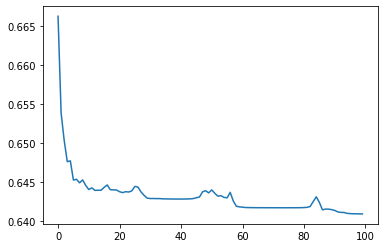

In [26]:
plt.plot(train_loss_tracker)

In [27]:
torch.save(model.state_dict(), "model/rgat_pretrained.pt")